<a href="https://colab.research.google.com/github/PrahasHegde/Blackjack_with_RL/blob/main/black_jack_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Strategy with Q-Learning


--- Training Agent ---
Starting Q-Learning training for 1000000 episodes...
Episode 50000/1000000, Epsilon: 0.9500, Avg Reward (last 50000 episodes): 0.0040
Episode 100000/1000000, Epsilon: 0.9000, Avg Reward (last 50000 episodes): -0.0605
Episode 150000/1000000, Epsilon: 0.8500, Avg Reward (last 50000 episodes): -0.0585
Episode 200000/1000000, Epsilon: 0.8000, Avg Reward (last 50000 episodes): -0.0520
Episode 250000/1000000, Epsilon: 0.7500, Avg Reward (last 50000 episodes): -0.0475
Episode 300000/1000000, Epsilon: 0.7000, Avg Reward (last 50000 episodes): 0.0115
Episode 350000/1000000, Epsilon: 0.6500, Avg Reward (last 50000 episodes): -0.0410
Episode 400000/1000000, Epsilon: 0.6000, Avg Reward (last 50000 episodes): 0.0025
Episode 450000/1000000, Epsilon: 0.5500, Avg Reward (last 50000 episodes): -0.0115
Episode 500000/1000000, Epsilon: 0.5000, Avg Reward (last 50000 episodes): -0.0100
Episode 550000/1000000, Epsilon: 0.4500, Avg Reward (last 50000 episodes): -0.1060
Episode 600000

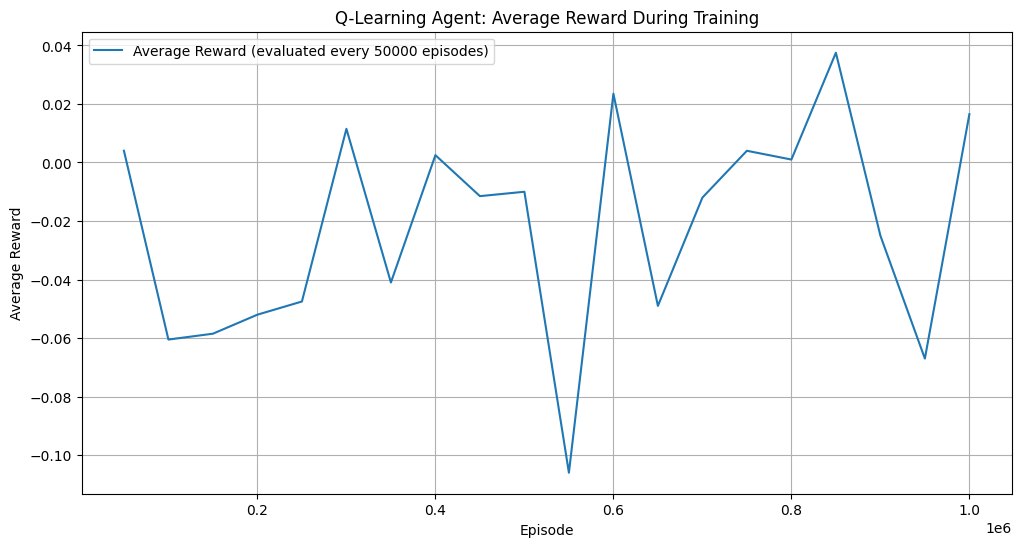

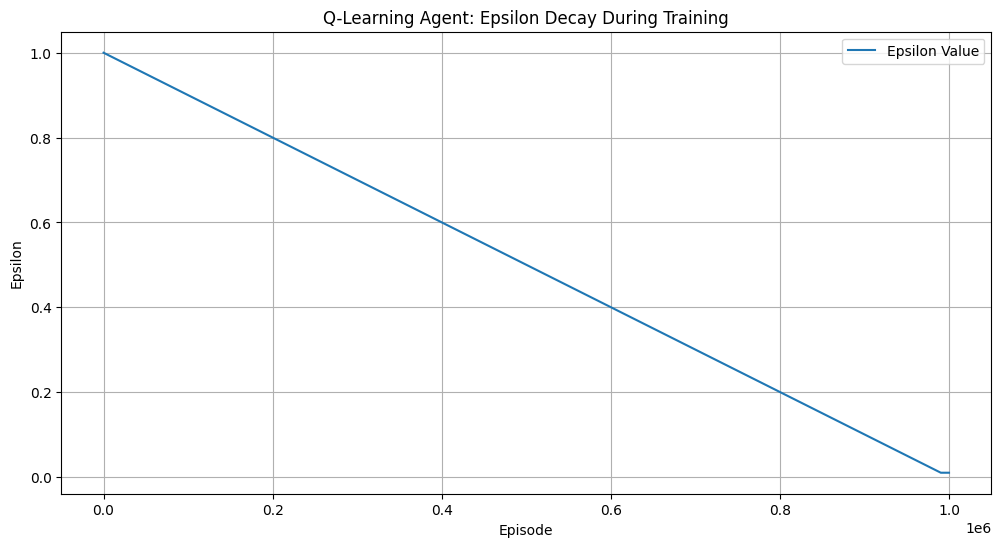

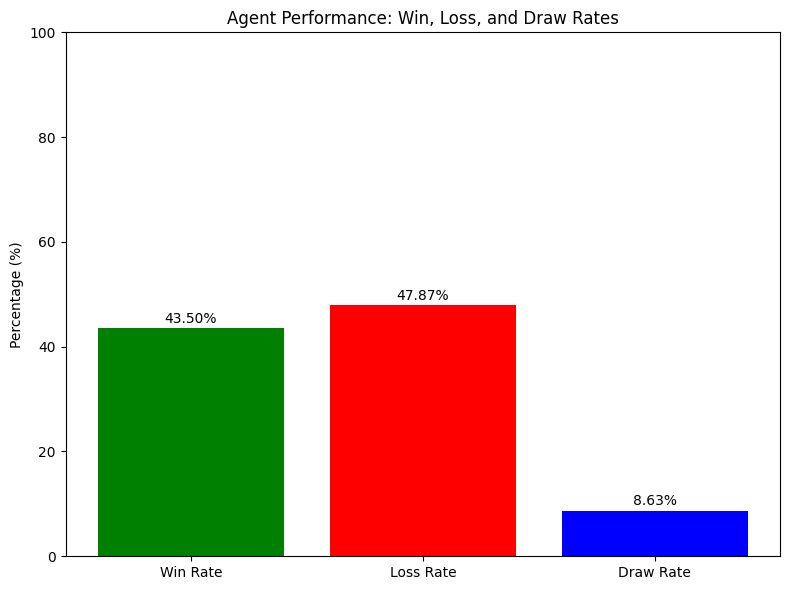

In [ ]:
import random
import numpy as np
import collections
import matplotlib.pyplot as plt

# Blackjack Environment
class BlackjackEnv:
    def __init__(self, num_decks=1, dealer_hits_soft_17=False, blackjack_payout_ratio=1.5):
        self.num_decks = num_decks
        self.deck = self._create_deck()
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.blackjack_payout_ratio = blackjack_payout_ratio
        self.reset()

    # Creating the deck and shuffling
    def _create_deck(self):
        ranks = [str(i) for i in range(2, 11)] + ['J', 'Q', 'K', 'A']
        suits = ['H', 'D', 'C', 'S']
        cards = [
            (rank, suit) for _ in range(self.num_decks) for rank in ranks for suit in suits
        ]
        random.shuffle(cards)
        return cards

    # Check if the deck is empty
    def _deal_card(self):
        if not self.deck:
            self.deck = self._create_deck()
        return self.deck.pop()

    # Calculate the value of Hand
    def _get_hand_value(self, hand):
        value = sum(self._get_card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card[0] == 'A')
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value, num_aces > 0 and value <= 21

    # Define card values
    def _get_card_value(self, card):
        rank = card[0]
        if rank in ['J', 'Q', 'K']:
            return 10
        elif rank == 'A':
            return 11
        else:
            return int(rank)

    #Dealer hand rules
    def _play_dealer_hand(self):
        while True:
            dealer_value, dealer_has_usable_ace = self._get_hand_value(self.dealer_hand)
            if dealer_value < 17: #ensuring sum >= 17
                self.dealer_hand.append(self._deal_card())
            elif dealer_value == 17 and self.dealer_hits_soft_17 and dealer_has_usable_ace:
                self.dealer_hand.append(self._deal_card())
            else:
                break
        return self._get_hand_value(self.dealer_hand)[0]

    # Win/Lose condition
    def _resolve_hand(self, player_hand_value, dealer_final_value):
        if player_hand_value > 21:
            return -1
        elif dealer_final_value > 21:
            return 1
        elif player_hand_value > dealer_final_value:
            return 1
        elif player_hand_value < dealer_final_value:
            return -1
        else:
            return 0

    # Sets up new hand of BlackJack
    def reset(self):
        #deal 2 cards to both to player and dealer
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]

        # get initial values of hands
        player_value, _ = self._get_hand_value(self.player_hand)
        dealer_value, _ = self._get_hand_value(self.dealer_hand)

        # Check for immediate blackjacks
        if player_value == 21 and len(self.player_hand) == 2:
            if dealer_value == 21 and len(self.dealer_hand) == 2:
                return self._get_state(), 0, True # Push
            else:
                return self._get_state(), self.blackjack_payout_ratio, True # Player Blackjack
        elif dealer_value == 21 and len(self.dealer_hand) == 2:
            return self._get_state(), -1, True # Dealer Blackjack

        return self._get_state(), 0, False

    # Tuple representing current state of the game, used by the Q Learning agent
    def _get_state(self):
        player_value, usable_ace = self._get_hand_value(self.player_hand)
        dealer_up_card_value = self._get_card_value(self.dealer_hand[0])
        can_double = (len(self.player_hand) == 2)
        can_split = (len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0])
        return (player_value, dealer_up_card_value, usable_ace, can_double, can_split)

    # Takes action taken by agent and updates the state
    def step(self, action):
        reward = 0
        done = False

        # Unpack state from the current hand to check validity
        player_value_current, _, usable_ace_current, can_double_current, can_split_current = self._get_state()

        # Action 0: Stand
        if action == 0:
            done = True
            dealer_final_value = self._play_dealer_hand()
            player_value, _ = self._get_hand_value(self.player_hand)
            reward = self._resolve_hand(player_value, dealer_final_value)

        # Action 1: Hit
        elif action == 1:
            self.player_hand.append(self._deal_card())
            player_value, _ = self._get_hand_value(self.player_hand)
            if player_value > 21:
                reward = -1
                done = True

        # Action 2: Double Down
        elif action == 2:
            if can_double_current:
                self.player_hand.append(self._deal_card())
                player_value, _ = self._get_hand_value(self.player_hand)
                done = True
                if player_value > 21:
                    reward = -2
                else:
                    dealer_final_value = self._play_dealer_hand()
                    reward = self._resolve_hand(player_value, dealer_final_value) * 2
            else:
                # If invalid, treat as a stand to penalize the agent.
                # This makes the agent learn not to take invalid actions.
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value)

        # Action 3: Split
        elif action == 3:
            if can_split_current:
                sum_of_hand_rewards = 0
                card1, card2 = self.player_hand

                # Simplified split logic: two hands are resolved sequentially.
                # A more complex Q-learning agent could learn to play each hand independently.

                # Hand 1
                hand1 = [card1, self._deal_card()]
                val1, _ = self._get_hand_value(hand1)
                while val1 < 17 and val1 <= 21:
                    hand1.append(self._deal_card())
                    val1, _ = self._get_hand_value(hand1)

                # Hand 2
                hand2 = [card2, self._deal_card()]
                val2, _ = self._get_hand_value(hand2)
                while val2 < 17 and val2 <= 21:
                    hand2.append(self._deal_card())
                    val2, _ = self._get_hand_value(hand2)

                dealer_final_value = self._play_dealer_hand()

                sum_of_hand_rewards += self._resolve_hand(val1, dealer_final_value)
                sum_of_hand_rewards += self._resolve_hand(val2, dealer_final_value)

                done = True
                reward = sum_of_hand_rewards
            else:
                # If invalid, treat as a stand to penalize the agent.
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value)

        return self._get_state(), reward, done, {}

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay_rate=0.000005, min_epsilon=0.01):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))
        self.action_map = {0: 'S', 1: 'H', 2: 'D', 3: 'P'}

    def choose_action(self, state):
        player_value, _, usable_ace, can_double, can_split = state

        valid_actions = [0, 1] # Stand and Hit are always valid
        if can_double:
            valid_actions.append(2)
        if can_split:
            valid_actions.append(3)

        if random.uniform(0, 1) < self.epsilon:
            # Explore: Choose from valid actions
            return random.choice(valid_actions)
        else:
            # Exploit: Choose the best valid action
            q_values = self.q_table[state]
            # Ensure we only pick from valid actions
            best_action = max(valid_actions, key=lambda a: q_values[a])
            return best_action

    def learn(self, state, action, reward, next_state, done):
        current_q = self.q_table[state][action]

        if done:
            max_next_q = 0 # No future reward in a terminal state
        else:
            # Get Q-values for the next state and find the max over valid actions
            _, _, _, next_can_double, next_can_split = next_state
            next_valid_actions = [0, 1]
            if next_can_double:
                next_valid_actions.append(2)
            if next_can_split:
                next_valid_actions.append(3)

            next_q_values = self.q_table[next_state]
            if not next_valid_actions: # Should not happen in non-terminal state, but good for robustness
                max_next_q = 0
            else:
                max_next_q = max(next_q_values[a] for a in next_valid_actions)

        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)

    def get_policy(self):
        policy = {}
        for state, actions_q_values in self.q_table.items():
            _, _, _, can_double, can_split = state
            valid_actions = [0, 1]
            if can_double:
                valid_actions.append(2)
            if can_split:
                valid_actions.append(3)

            if not valid_actions:
                policy[state] = 'N/A'
            else:
                best_action = max(valid_actions, key=lambda a: actions_q_values[a])
                policy[state] = self.action_map[best_action]
        return policy

# --- Training and Evaluation Functions ---
def train_agent(env, agent, num_episodes, log_interval):
    avg_rewards_history = []
    episodes_history = []
    epsilon_history = []

    print(f"Starting Q-Learning training for {num_episodes} episodes...")
    for episode in range(num_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon)

        if (episode + 1) % log_interval == 0:
            # Calculate average reward over the last `log_interval` episodes
            # The previous code had a bug here, using epsilon_history for avg_reward
            current_total_rewards_slice = []
            # Rerun a small number of evaluation hands without exploration to get a true current reward
            # This is more robust than summing episode_rewards which can be very noisy
            # and may not reflect the current policy well during training
            original_epsilon_temp = agent.epsilon
            agent.epsilon = 0.0 # Temporarily set to greedy for a quick evaluation slice

            temp_rewards = []
            for _ in range(1000): # Evaluate over 1000 games for this log point
                eval_state, eval_initial_reward, eval_done = env.reset()
                eval_episode_reward = eval_initial_reward
                while not eval_done:
                    eval_action = agent.choose_action(eval_state)
                    eval_state, eval_reward, eval_done, _ = env.step(eval_action)
                    eval_episode_reward += eval_reward
                temp_rewards.append(eval_episode_reward)
            avg_reward = np.mean(temp_rewards)

            agent.epsilon = original_epsilon_temp # Restore epsilon

            avg_rewards_history.append(avg_reward)
            episodes_history.append(episode + 1)
            print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {agent.epsilon:.4f}, Avg Reward (last {log_interval} episodes): {avg_reward:.4f}")

    print("Training complete.")
    return avg_rewards_history, episodes_history, epsilon_history

def evaluate_agent(env, agent, num_evaluation_episodes):
    print(f"\nEvaluating agent over {num_evaluation_episodes} episodes (greedy policy)...")
    rewards = []
    wins, losses, draws = 0, 0, 0
    player_blackjacks_count = 0
    dealer_blackjacks_count = 0

    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    for episode in range(num_evaluation_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        # Check for immediate blackjacks after reset for counting purposes
        player_value, _, _, _, _ = env._get_state()
        dealer_value, _ = env._get_hand_value(env.dealer_hand) # Need full dealer hand value for this check

        is_player_natural = (player_value == 21 and len(env.player_hand) == 2)
        is_dealer_natural = (dealer_value == 21 and len(env.dealer_hand) == 2)

        if is_player_natural and not is_dealer_natural:
            player_blackjacks_count += 1
        elif is_dealer_natural and not is_player_natural:
            dealer_blackjacks_count += 1

        while not done:
            action = agent.choose_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward

        rewards.append(episode_reward)
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = np.mean(rewards)
    win_rate = (wins / num_evaluation_episodes) * 100
    loss_rate = (losses / num_evaluation_episodes) * 100
    draw_rate = (draws / num_evaluation_episodes) * 100

    agent.epsilon = original_epsilon
    return avg_reward, win_rate, loss_rate, draw_rate, player_blackjacks_count, dealer_blackjacks_count

# Main Execution
if __name__ == "__main__":
    env = BlackjackEnv(num_decks=1, dealer_hits_soft_17=False)
    ACTIONS = [0, 1, 2, 3] # Stand, Hit, Double, Split
    agent = QLearningAgent(actions=ACTIONS, epsilon_decay_rate=0.000001)

    num_training_episodes = 1000000 # Increased for better convergence
    num_evaluation_episodes = 100000
    log_interval = 50000 # Adjusted log interval

    print("\n--- Training Agent ---")
    avg_rewards_history, episodes_history, epsilon_history = train_agent(env, agent, num_training_episodes, log_interval)

    print("\n--- Evaluating Agent ---")
    expected_profit, win_rate, loss_rate, draw_rate, p_bjs, d_bjs = evaluate_agent(env, agent, num_evaluation_episodes)

    print(f"\n--- Summary of Agent Performance ---")
    print(f"Expected profit per hand: {expected_profit:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Player Natural Blackjacks: {p_bjs}")
    print(f"Dealer Natural Blackjacks: {d_bjs}")


    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(episodes_history, avg_rewards_history, label=f'Average Reward (evaluated every {log_interval} episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning Agent: Average Reward During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(epsilon_history)), epsilon_history, label='Epsilon Value')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Q-Learning Agent: Epsilon Decay During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    metrics = ['Win Rate', 'Loss Rate', 'Draw Rate']
    values = [win_rate, loss_rate, draw_rate]
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['green', 'red', 'blue'])
    plt.ylabel('Percentage (%)')
    plt.title('Agent Performance: Win, Loss, and Draw Rates')
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

## Complete Point count system and Q-Learning


--- Training Agent with Card Counting ---
Starting Q-Learning training for 2000000 episodes...
Episode 500000/2000000, Epsilon: 0.7500, Avg Reward (last evaluation): 0.0020
Episode 1000000/2000000, Epsilon: 0.5000, Avg Reward (last evaluation): 0.0250
Episode 1500000/2000000, Epsilon: 0.2500, Avg Reward (last evaluation): 0.0030
Episode 2000000/2000000, Epsilon: 0.0100, Avg Reward (last evaluation): 0.0370
Training complete.

--- Evaluating Agent ---

Evaluating agent over 200000 episodes (greedy policy)...

--- Summary of Agent Performance ---
Expected profit per hand (with Hi-Lo counting): -0.0164
Win Rate: 43.06%
Loss Rate: 48.22%
Draw Rate: 8.72%
Player Natural Blackjacks: 9036
Dealer Natural Blackjacks: 9181

--- Generating Plots ---


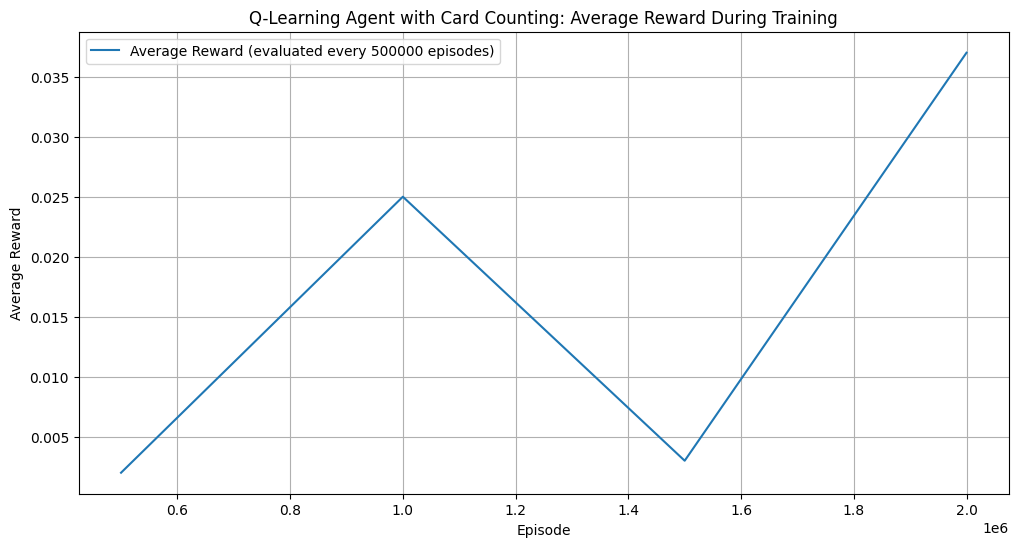

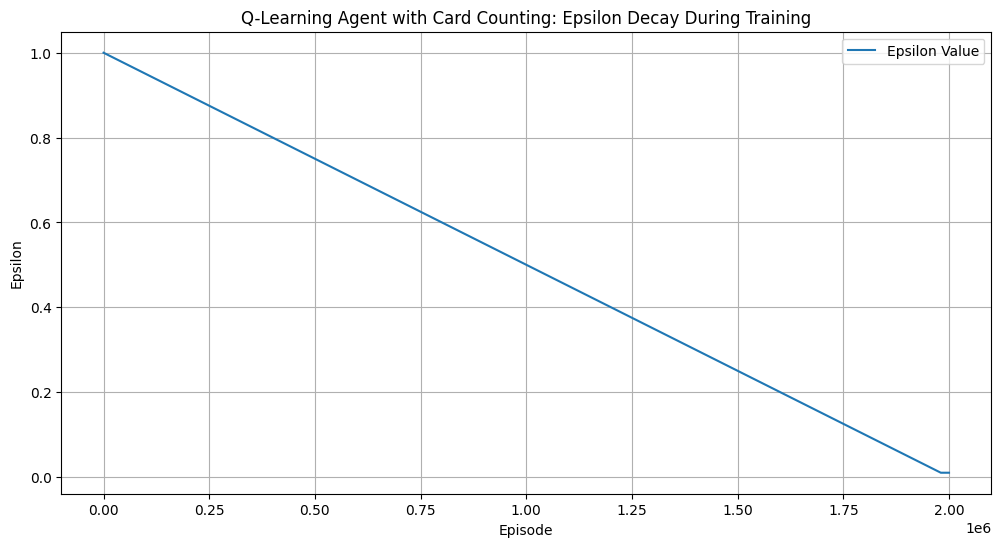

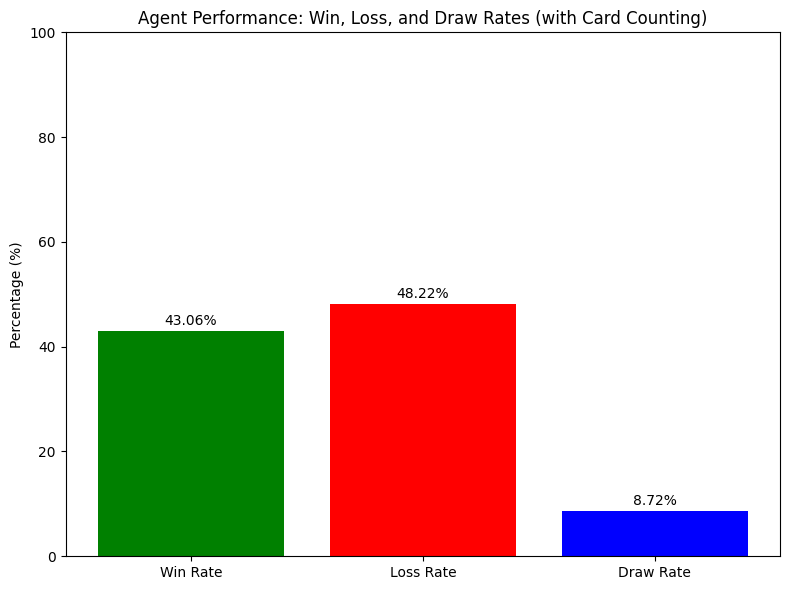

In [ ]:
# --- Blackjack Environment ---
class BlackjackEnv:
    def __init__(self, num_decks=1, dealer_hits_soft_17=False, blackjack_payout_ratio=1.5):
        self.num_decks = num_decks
        self.deck = self._create_deck()
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.blackjack_payout_ratio = blackjack_payout_ratio

        # Card Counting variables
        self.running_count = 0
        self.cards_dealt_count = 0 # To track how many cards have been dealt from the shoe

        self.reset()

    def _create_deck(self):
        ranks = [str(i) for i in range(2, 11)] + ['J', 'Q', 'K', 'A']
        suits = ['H', 'D', 'C', 'S']
        cards = [
            (rank, suit) for _ in range(self.num_decks) for rank in ranks for suit in suits
        ]
        random.shuffle(cards)
        return cards


    #card counting strategy
    def _get_card_count_value(self, card):
        rank = card[0]
        if rank in ['2', '3', '4', '5', '6']:
            return 1
        elif rank in ['10', 'J', 'Q', 'K', 'A']:
            return -1
        else: # 7, 8, 9
            return 0

    def _deal_card(self):
        if not self.deck or len(self.deck) < self.num_decks * 52 * 0.25: # Reshuffle if deck is low (e.g., 25% remaining)
            # print("Reshuffling deck...") # For debugging reshuffles
            self.deck = self._create_deck()
            self.running_count = 0 # Reset count on reshuffle
            self.cards_dealt_count = 0

        card = self.deck.pop()
        self.running_count += self._get_card_count_value(card)
        self.cards_dealt_count += 1
        return card

    def _get_hand_value(self, hand):
        value = sum(self._get_card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card[0] == 'A')
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value, num_aces > 0 and value <= 21

    def _get_card_value(self, card):
        rank = card[0]
        if rank in ['J', 'Q', 'K']:
            return 10
        elif rank == 'A':
            return 11
        else:
            return int(rank)

    def _play_dealer_hand(self):
        while True:
            dealer_value, dealer_has_usable_ace = self._get_hand_value(self.dealer_hand)
            if dealer_value < 17:
                self.dealer_hand.append(self._deal_card())
            elif dealer_value == 17 and self.dealer_hits_soft_17 and dealer_has_usable_ace:
                self.dealer_hand.append(self._deal_card())
            else:
                break
        return self._get_hand_value(self.dealer_hand)[0]

    def _resolve_hand(self, player_hand_value, dealer_final_value):
        if player_hand_value > 21:
            return -1
        elif dealer_final_value > 21:
            return 1
        elif player_hand_value > dealer_final_value:
            return 1
        elif player_hand_value < dealer_final_value:
            return -1
        else:
            return 0

    def reset(self):
        # Deal initial cards for counting
        card1_p = self._deal_card()
        card1_d = self._deal_card()
        card2_p = self._deal_card()
        card2_d = self._deal_card()

        self.player_hand = [card1_p, card2_p]
        self.dealer_hand = [card1_d, card2_d]

        player_value, _ = self._get_hand_value(self.player_hand)
        dealer_value, _ = self._get_hand_value(self.dealer_hand)

        # Check for immediate blackjacks
        if player_value == 21 and len(self.player_hand) == 2:
            if dealer_value == 21 and len(self.dealer_hand) == 2:
                return self._get_state(), 0, True # Push
            else:
                return self._get_state(), self.blackjack_payout_ratio, True # Player Blackjack
        elif dealer_value == 21 and len(self.dealer_hand) == 2:
            return self._get_state(), -1, True # Dealer Blackjack

        return self._get_state(), 0, False

    def _get_state(self):
        player_value, usable_ace = self._get_hand_value(self.player_hand)
        dealer_up_card_value = self._get_card_value(self.dealer_hand[0])
        can_double = (len(self.player_hand) == 2)
        can_split = (len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0])

        # Calculate True Count for the state
        remaining_decks = max(1, (self.num_decks * 52 - self.cards_dealt_count) / 52)
        true_count = self.running_count / remaining_decks if remaining_decks > 0 else 0

        # Bin true count for state space reduction (essential for Q-learning)
        if true_count < -2:
            binned_true_count = -3
        elif true_count <= -1:
            binned_true_count = -2
        elif true_count == 0:
            binned_true_count = 0
        elif true_count <= 1:
            binned_true_count = 1
        elif true_count <= 2:
            binned_true_count = 2
        else: # true_count > 2
            binned_true_count = 3

        # State tuple: (player_sum, dealer_upcard, usable_ace, can_double, can_split, binned_true_count)
        return (player_value, dealer_up_card_value, usable_ace, can_double, can_split, binned_true_count)

    def step(self, action):
        reward = 0
        done = False

        # Unpack state from the current hand to check validity
        player_value_current, _, usable_ace_current, can_double_current, can_split_current, _ = self._get_state()

        # Action 0: Stand
        if action == 0:
            done = True
            dealer_final_value = self._play_dealer_hand()
            player_value, _ = self._get_hand_value(self.player_hand)
            reward = self._resolve_hand(player_value, dealer_final_value)

        # Action 1: Hit
        elif action == 1:
            self.player_hand.append(self._deal_card())
            player_value, _ = self._get_hand_value(self.player_hand)
            if player_value > 21:
                reward = -1
                done = True

        # Action 2: Double Down
        elif action == 2:
            if can_double_current:
                self.player_hand.append(self._deal_card())
                player_value, _ = self._get_hand_value(self.player_hand)
                done = True
                if player_value > 21:
                    reward = -2
                else:
                    dealer_final_value = self._play_dealer_hand()
                    reward = self._resolve_hand(player_value, dealer_final_value) * 2
            else:
                # If invalid, treat as a stand to penalize the agent.
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value)

        # Action 3: Split
        elif action == 3:
            if can_split_current:
                sum_of_hand_rewards = 0
                card1, card2 = self.player_hand

                # Simplified split logic: two hands are resolved sequentially.
                # In a full Thorp system, you'd play each split hand optimally, including re-splitting.
                # Here, for Q-learning simplicity, we just deal one card and stand on 17+ or bust
                # if not aces. This keeps the environment simpler for the agent to learn.

                # Hand 1
                hand1 = [card1, self._deal_card()]
                val1, _ = self._get_hand_value(hand1)
                # If it's not aces, play out the hand (hit until 17 or bust)
                if card1[0] != 'A':
                    while val1 < 17 and val1 <= 21:
                        hand1.append(self._deal_card())
                        val1, _ = self._get_hand_value(hand1)

                # Hand 2
                hand2 = [card2, self._deal_card()]
                val2, _ = self._get_hand_value(hand2)
                if card2[0] != 'A':
                    while val2 < 17 and val2 <= 21:
                        hand2.append(self._deal_card())
                        val2, _ = self._get_hand_value(hand2)

                dealer_final_value = self._play_dealer_hand()

                sum_of_hand_rewards += self._resolve_hand(val1, dealer_final_value)
                sum_of_hand_rewards += self._resolve_hand(val2, dealer_final_value)

                done = True
                reward = sum_of_hand_rewards
            else:
                # If invalid, treat as a stand to penalize the agent.
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value)

        return self._get_state(), reward, done, {}

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay_rate=0.000005, min_epsilon=0.01):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))
        self.action_map = {0: 'S', 1: 'H', 2: 'D', 3: 'P'}

    def choose_action(self, state):
        player_value, dealer_up_card_value, usable_ace, can_double, can_split, binned_true_count = state

        valid_actions = [0, 1] # Stand and Hit are always valid
        if can_double:
            valid_actions.append(2)
        if can_split:
            valid_actions.append(3)

        if random.uniform(0, 1) < self.epsilon:
            # Explore: Choose from valid actions
            return random.choice(valid_actions)
        else:
            # Exploit: Choose the best valid action
            q_values = self.q_table[state]
            # Ensure we only pick from valid actions
            best_action = max(valid_actions, key=lambda a: q_values[a])
            return best_action

    def learn(self, state, action, reward, next_state, done):
        current_q = self.q_table[state][action]

        if done:
            max_next_q = 0 # No future reward in a terminal state
        else:
            # Get Q-values for the next state and find the max over valid actions
            _, _, _, next_can_double, next_can_split, _ = next_state
            next_valid_actions = [0, 1]
            if next_can_double:
                next_valid_actions.append(2)
            if next_can_split:
                next_valid_actions.append(3)

            next_q_values = self.q_table[next_state]
            if not next_valid_actions:
                max_next_q = 0
            else:
                max_next_q = max(next_q_values[a] for a in next_valid_actions)

        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)

    def get_policy(self):
        policy = {}
        for state, actions_q_values in self.q_table.items():
            _, _, _, can_double, can_split, _ = state
            valid_actions = [0, 1]
            if can_double:
                valid_actions.append(2)
            if can_split:
                valid_actions.append(3)

            if not valid_actions:
                policy[state] = 'N/A'
            else:
                best_action = max(valid_actions, key=lambda a: actions_q_values[a])
                policy[state] = self.action_map[best_action]
        return policy

# --- Training and Evaluation Functions ---
def train_agent(env, agent, num_episodes, log_interval):
    avg_rewards_history = []
    episodes_history = []
    epsilon_history = []

    print(f"Starting Q-Learning training for {num_episodes} episodes...")
    for episode in range(num_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon)

        if (episode + 1) % log_interval == 0:
            original_epsilon_temp = agent.epsilon
            agent.epsilon = 0.0 # Temporarily set to greedy for a quick evaluation slice

            temp_rewards = []
            for _ in range(1000): # Evaluate over 1000 games for this log point
                eval_state, eval_initial_reward, eval_done = env.reset()
                eval_episode_reward = eval_initial_reward
                while not eval_done:
                    eval_action = agent.choose_action(eval_state)
                    eval_state, eval_reward, eval_done, _ = env.step(eval_action)
                    eval_episode_reward += eval_reward
                temp_rewards.append(eval_episode_reward)
            avg_reward = np.mean(temp_rewards)

            agent.epsilon = original_epsilon_temp # Restore epsilon

            avg_rewards_history.append(avg_reward)
            episodes_history.append(episode + 1)
            print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {agent.epsilon:.4f}, Avg Reward (last evaluation): {avg_reward:.4f}")

    print("Training complete.")
    return avg_rewards_history, episodes_history, epsilon_history

def evaluate_agent(env, agent, num_evaluation_episodes):
    print(f"\nEvaluating agent over {num_evaluation_episodes} episodes (greedy policy)...")
    rewards = []
    wins, losses, draws = 0, 0, 0
    player_blackjacks_count = 0
    dealer_blackjacks_count = 0

    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    for episode in range(num_evaluation_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        # Check for immediate blackjacks after reset for counting purposes
        player_value, _, _, _, _, _ = env._get_state() # Get player value from the state
        dealer_value, _ = env._get_hand_value(env.dealer_hand) # Get full dealer hand value for this check

        is_player_natural = (player_value == 21 and len(env.player_hand) == 2)
        is_dealer_natural = (dealer_value == 21 and len(env.dealer_hand) == 2)

        if is_player_natural and not is_dealer_natural:
            player_blackjacks_count += 1
        elif is_dealer_natural and not is_player_natural:
            dealer_blackjacks_count += 1

        while not done:
            action = agent.choose_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward

        rewards.append(episode_reward)
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = np.mean(rewards)
    win_rate = (wins / num_evaluation_episodes) * 100
    loss_rate = (losses / num_evaluation_episodes) * 100
    draw_rate = (draws / num_evaluation_episodes) * 100

    agent.epsilon = original_epsilon
    return avg_reward, win_rate, loss_rate, draw_rate, player_blackjacks_count, dealer_blackjacks_count

# --- Main Execution ---
if __name__ == "__main__":
    env = BlackjackEnv(num_decks=6, dealer_hits_soft_17=False) # Common casino rules
    ACTIONS = [0, 1, 2, 3] # 0: Stand, 1: Hit, 2: Double Down, 3: Split
    agent = QLearningAgent(actions=ACTIONS, epsilon_decay_rate=0.0000005) # Slower decay for larger state space

    num_training_episodes = 2000000 # Significant number for count-based strategy
    num_evaluation_episodes = 200000
    log_interval = 500000 # Evaluate and log less frequently due to longer training

    print("\n--- Training Agent with Card Counting ---")
    avg_rewards_history, episodes_history, epsilon_history = train_agent(env, agent, num_training_episodes, log_interval)

    print("\n--- Evaluating Agent ---")
    expected_profit, win_rate, loss_rate, draw_rate, p_bjs, d_bjs = evaluate_agent(env, agent, num_evaluation_episodes)

    print(f"\n--- Summary of Agent Performance ---")
    print(f"Expected profit per hand (with Hi-Lo counting): {expected_profit:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Player Natural Blackjacks: {p_bjs}")
    print(f"Dealer Natural Blackjacks: {d_bjs}")

    # --- Plotting ---
    print("\n--- Generating Plots ---")

    plt.figure(figsize=(12, 6))
    plt.plot(episodes_history, avg_rewards_history, label=f'Average Reward (evaluated every {log_interval} episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Q-Learning Agent with Card Counting: Average Reward During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(epsilon_history)), epsilon_history, label='Epsilon Value')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Q-Learning Agent with Card Counting: Epsilon Decay During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    metrics = ['Win Rate', 'Loss Rate', 'Draw Rate']
    values = [win_rate, loss_rate, draw_rate]
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['green', 'red', 'blue'])
    plt.ylabel('Percentage (%)')
    plt.title('Agent Performance: Win, Loss, and Draw Rates (with Card Counting)')
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

## Improving Complete Point Count System using SARSA


--- Training SARSA Agent with Card Counting and Dynamic Betting ---
Starting SARSA training for 2000000 episodes...
Episode 50000/2000000, Epsilon: 0.9600, Avg Reward (last evaluation): -0.0460
Episode 100000/2000000, Epsilon: 0.9200, Avg Reward (last evaluation): 0.0230
Episode 150000/2000000, Epsilon: 0.8800, Avg Reward (last evaluation): 0.0480
Episode 200000/2000000, Epsilon: 0.8400, Avg Reward (last evaluation): 0.0755
Episode 250000/2000000, Epsilon: 0.8000, Avg Reward (last evaluation): 0.0198
Episode 300000/2000000, Epsilon: 0.7600, Avg Reward (last evaluation): 0.0553
Episode 350000/2000000, Epsilon: 0.7200, Avg Reward (last evaluation): -0.0418
Episode 400000/2000000, Epsilon: 0.6800, Avg Reward (last evaluation): -0.0393
Episode 450000/2000000, Epsilon: 0.6400, Avg Reward (last evaluation): -0.0070
Episode 500000/2000000, Epsilon: 0.6000, Avg Reward (last evaluation): 0.0315
Episode 550000/2000000, Epsilon: 0.5600, Avg Reward (last evaluation): 0.0270
Episode 600000/2000000

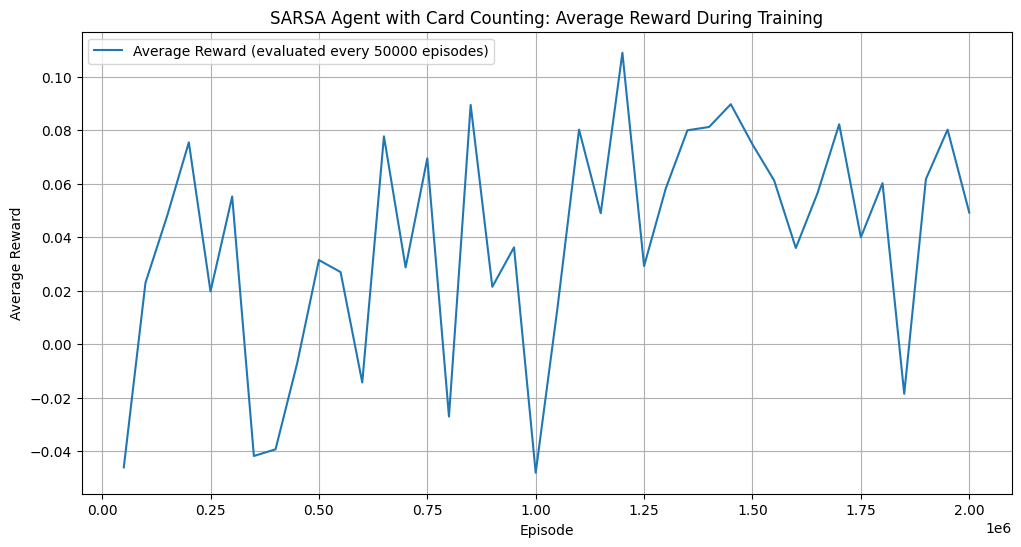

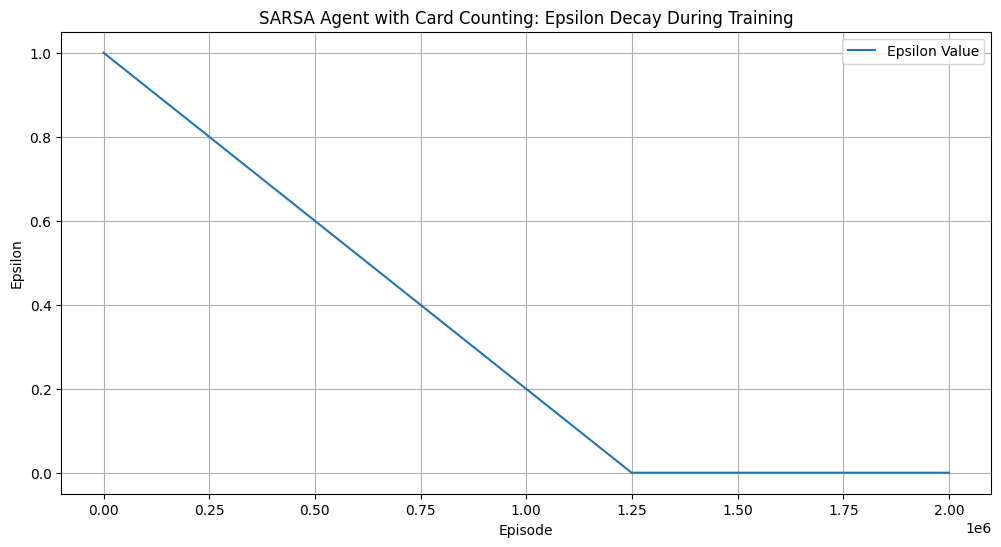

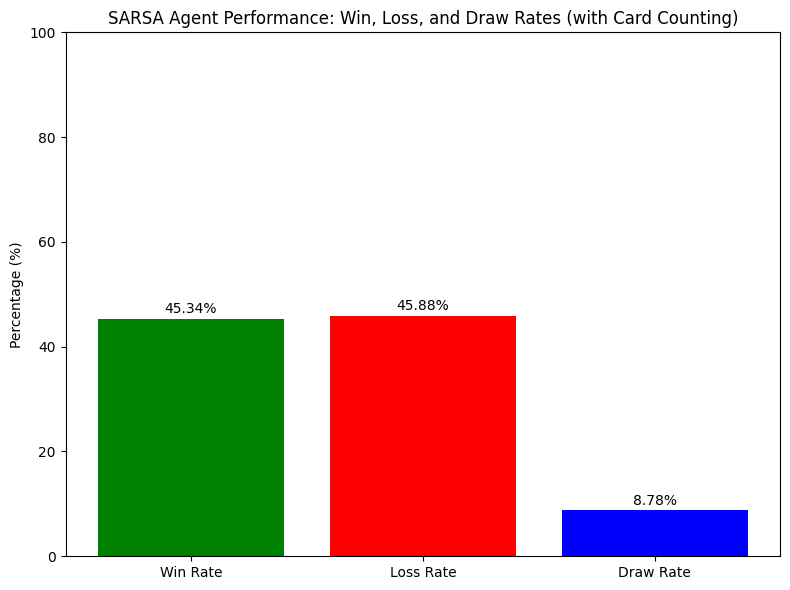

In [ ]:
import random
import numpy as np
import collections
import matplotlib.pyplot as plt

# Hyperparameters
LEARNING_RATE = 0.01  # Alpha
DISCOUNT_FACTOR = 0.99 # Gamma
EPSILON_START = 1.0
EPSILON_DECAY_RATE = 0.0000008 # Slower decay rate for more exploration
MIN_EPSILON = 0.001
NUM_DECKS = 1
DEALER_HITS_SOFT_17 = False
BLACKJACK_PAYOUT_RATIO = 1.5

# --- Blackjack Environment (remains the same as before) ---
class BlackjackEnv:
    def __init__(self, num_decks=NUM_DECKS, dealer_hits_soft_17=DEALER_HITS_SOFT_17, blackjack_payout_ratio=BLACKJACK_PAYOUT_RATIO):
        self.num_decks = num_decks
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.blackjack_payout_ratio = blackjack_payout_ratio

        self.deck = self._create_deck()
        self.running_count = 0
        self.cards_dealt_count = 0
        self.initial_bet_size = 1 # The bet size for the current hand

        self.reset()

    def _create_deck(self):
        ranks = [str(i) for i in range(2, 11)] + ['J', 'Q', 'K', 'A']
        suits = ['H', 'D', 'C', 'S']
        cards = [(rank, suit) for _ in range(self.num_decks) for rank in ranks for suit in suits]
        random.shuffle(cards)
        return cards

    def _get_card_count_value(self, card):
        rank = card[0]
        if rank in ['2', '3', '4', '5', '6']:
            return 1
        elif rank in ['10', 'J', 'Q', 'K', 'A']:
            return -1
        else: # 7, 8, 9
            return 0

    def _deal_card(self):
        if not self.deck or len(self.deck) < 52 * 1.5:
            self.deck = self._create_deck()
            self.running_count = 0
            self.cards_dealt_count = 0

        card = self.deck.pop()
        self.running_count += self._get_card_count_value(card)
        self.cards_dealt_count += 1
        return card

    def _get_hand_value(self, hand):
        value = sum(self._get_card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card[0] == 'A')
        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1
        return value, num_aces > 0 and value <= 21

    def _get_card_value(self, card):
        rank = card[0]
        if rank in ['J', 'Q', 'K']:
            return 10
        elif rank == 'A':
            return 11
        else:
            return int(rank)

    def _play_dealer_hand(self):
        while True:
            dealer_value, dealer_has_usable_ace = self._get_hand_value(self.dealer_hand)
            if dealer_value < 17:
                self.dealer_hand.append(self._deal_card())
            elif dealer_value == 17 and self.dealer_hits_soft_17 and dealer_has_usable_ace:
                self.dealer_hand.append(self._deal_card())
            else:
                break
        return self._get_hand_value(self.dealer_hand)[0]

    def _resolve_hand(self, player_hand_value, dealer_final_value):
        if player_hand_value > 21:
            return -1 # Player busts
        elif dealer_final_value > 21:
            return 1 # Dealer busts
        elif player_hand_value > dealer_final_value:
            return 1 # Player wins
        elif player_hand_value < dealer_final_value:
            return -1 # Dealer wins
        else:
            return 0 # Push (tie)

    def get_true_count(self):
        remaining_decks = max(1, (self.num_decks * 52 - self.cards_dealt_count) / 52)
        return self.running_count / remaining_decks if remaining_decks > 0 else 0

    def _get_binned_true_count(self):
        true_count = self.get_true_count()
        if true_count < -2.5: return 0
        elif true_count < -1.5: return 1
        elif true_count < -0.5: return 2
        elif true_count < 0.5: return 3
        elif true_count < 1.5: return 4
        elif true_count < 2.5: return 5
        elif true_count < 3.5: return 6
        else: return 7

    def get_bet_size(self):
        binned_count = self._get_binned_true_count()
        if binned_count >= 7: return 5
        elif binned_count >= 6: return 4
        elif binned_count >= 5: return 3
        elif binned_count >= 4: return 2
        else: return 1

    def reset(self):
        self.initial_bet_size = self.get_bet_size()

        card1_p = self._deal_card()
        card1_d = self._deal_card()
        card2_p = self._deal_card()
        card2_d = self._deal_card()

        self.player_hand = [card1_p, card2_p]
        self.dealer_hand = [card1_d, card2_d]

        player_value, _ = self._get_hand_value(self.player_hand)
        dealer_value, _ = self._get_hand_value(self.dealer_hand)

        if player_value == 21 and len(self.player_hand) == 2:
            if dealer_value == 21 and len(self.dealer_hand) == 2:
                return self._get_state(), 0, True
            else:
                return self._get_state(), self.blackjack_payout_ratio * self.initial_bet_size, True
        elif dealer_value == 21 and len(self.dealer_hand) == 2:
            return self._get_state(), -1 * self.initial_bet_size, True

        return self._get_state(), 0, False

    def _get_state(self):
        player_value, usable_ace = self._get_hand_value(self.player_hand)
        dealer_up_card_value = self._get_card_value(self.dealer_hand[0])
        can_double = (len(self.player_hand) == 2)
        can_split = (len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0])

        binned_true_count = self._get_binned_true_count()

        return (player_value, dealer_up_card_value, int(usable_ace), int(can_double), int(can_split), binned_true_count)

    def step(self, action):
        reward = 0
        done = False

        player_value_current, _, _, can_double_current, can_split_current, _ = self._get_state()

        if action == 0: # Stand
            done = True
            dealer_final_value = self._play_dealer_hand()
            player_value, _ = self._get_hand_value(self.player_hand)
            reward = self._resolve_hand(player_value, dealer_final_value)

        elif action == 1: # Hit
            self.player_hand.append(self._deal_card())
            player_value, _ = self._get_hand_value(self.player_hand)
            if player_value > 21:
                reward = -1
                done = True

        elif action == 2: # Double Down
            if can_double_current:
                self.player_hand.append(self._deal_card())
                player_value, _ = self._get_hand_value(self.player_hand)
                done = True
                if player_value > 21:
                    reward = -2
                else:
                    dealer_final_value = self._play_dealer_hand()
                    reward = self._resolve_hand(player_value, dealer_final_value) * 2
            else:
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value) - 0.5

        elif action == 3: # Split
            if can_split_current:
                sum_of_hand_rewards = 0
                card1, card2 = self.player_hand

                hand1 = [card1, self._deal_card()]
                val1, _ = self._get_hand_value(hand1)
                if card1[0] != 'A':
                    while val1 < 17 and val1 <= 21:
                        hand1.append(self._deal_card())
                        val1, _ = self._get_hand_value(hand1)

                hand2 = [card2, self._deal_card()]
                val2, _ = self._get_hand_value(hand2)
                if card2[0] != 'A':
                    while val2 < 17 and val2 <= 21:
                        hand2.append(self._deal_card())
                        val2, _ = self._get_hand_value(hand2)

                dealer_final_value = self._play_dealer_hand()

                sum_of_hand_rewards += self._resolve_hand(val1, dealer_final_value)
                sum_of_hand_rewards += self._resolve_hand(val2, dealer_final_value)

                done = True
                reward = sum_of_hand_rewards
            else:
                done = True
                dealer_final_value = self._play_dealer_hand()
                player_value, _ = self._get_hand_value(self.player_hand)
                reward = self._resolve_hand(player_value, dealer_final_value) - 0.5

        return self._get_state(), reward * self.initial_bet_size, done, {}

# --- SARSA Agent ---
class SARSAAgent:
    def __init__(self, actions, learning_rate=0.01, discount_factor=0.99,
                 epsilon_start=1.0, epsilon_decay_rate=0.0000008, min_epsilon=0.001):
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay_rate
        self.min_epsilon = min_epsilon

        self.q_table = collections.defaultdict(lambda: np.zeros(len(self.actions)))

    def choose_action(self, state):
        _, _, _, can_double, can_split, _ = state

        valid_actions = [0, 1]
        if can_double:
            valid_actions.append(2)
        if can_split:
            valid_actions.append(3)

        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_actions)
        else:
            q_values_for_state = self.q_table[state]

            masked_q_values = q_values_for_state.copy()
            for i in range(len(self.actions)):
                if i not in valid_actions:
                    masked_q_values[i] = -np.inf

            if np.all(np.isinf(masked_q_values)):
                return random.choice(valid_actions)
            else:
                return np.argmax(masked_q_values)

    def learn(self, state, action, reward, next_state, next_action, done): # next_action is added for SARSA
        current_q = self.q_table[state][action]

        if done:
            target_q = reward
        else:
            # SARSA update: uses Q(s', a') where a' is the *next action actually taken*
            # This is the key difference from Q-learning
            target_q = reward + self.discount_factor * self.q_table[next_state][next_action]

        self.q_table[state][action] += self.learning_rate * (target_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

# --- Training and Evaluation Functions (modified for SARSA) ---
def train_agent(env, agent, num_episodes, log_interval):
    avg_rewards_history = []
    episodes_history = []
    epsilon_history = []

    print(f"Starting SARSA training for {num_episodes} episodes...")
    for episode in range(num_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        # SARSA requires choosing the next action *before* the learn step
        action = agent.choose_action(state)

        while not done:
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            if not done:
                next_action = agent.choose_action(next_state) # Choose next action based on current policy
                agent.learn(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            else: # If it's a terminal state, learn with reward only
                agent.learn(state, action, reward, next_state, None, done) # next_action is not used here

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon)

        if (episode + 1) % log_interval == 0:
            original_epsilon_temp = agent.epsilon
            agent.epsilon = 0.0 # Temporarily set to greedy for evaluation

            temp_rewards = []
            for _ in range(2000):
                eval_state, eval_initial_reward, eval_done = env.reset()
                eval_episode_reward = eval_initial_reward
                while not eval_done:
                    eval_action = agent.choose_action(eval_state)
                    eval_state, eval_reward, eval_done, _ = env.step(eval_action)
                    eval_episode_reward += eval_reward
                temp_rewards.append(eval_episode_reward)
            avg_reward = np.mean(temp_rewards)

            agent.epsilon = original_epsilon_temp

            avg_rewards_history.append(avg_reward)
            episodes_history.append(episode + 1)
            print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {agent.epsilon:.4f}, Avg Reward (last evaluation): {avg_reward:.4f}")

    print("SARSA Training complete.")
    return avg_rewards_history, episodes_history, epsilon_history

def evaluate_agent(env, agent, num_evaluation_episodes):
    print(f"\nEvaluating agent over {num_evaluation_episodes} episodes (greedy policy)...")
    rewards = []
    wins, losses, draws = 0, 0, 0
    player_blackjacks_count = 0
    dealer_blackjacks_count = 0

    original_epsilon = agent.epsilon
    agent.epsilon = 0.0 # Set to greedy for evaluation

    for episode in range(num_evaluation_episodes):
        state, initial_reward, done = env.reset()
        episode_reward = initial_reward

        player_value, _, _, _, _, _ = state
        dealer_value, _ = env._get_hand_value(env.dealer_hand)

        is_player_natural = (player_value == 21 and len(env.player_hand) == 2)
        is_dealer_natural = (dealer_value == 21 and len(env.dealer_hand) == 2)

        if is_player_natural and not is_dealer_natural:
            player_blackjacks_count += 1
        elif is_dealer_natural and not is_player_natural:
            dealer_blackjacks_count += 1

        while not done:
            action = agent.choose_action(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward

        rewards.append(episode_reward)
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    avg_reward = np.mean(rewards)
    win_rate = (wins / num_evaluation_episodes) * 100
    loss_rate = (losses / num_evaluation_episodes) * 100
    draw_rate = (draws / num_evaluation_episodes) * 100

    agent.epsilon = original_epsilon
    return avg_reward, win_rate, loss_rate, draw_rate, player_blackjacks_count, dealer_blackjacks_count

# --- Main Execution ---
if __name__ == "__main__":
    env = BlackjackEnv(num_decks=NUM_DECKS, dealer_hits_soft_17=DEALER_HITS_SOFT_17)
    ACTIONS = [0, 1, 2, 3] # 0: Stand, 1: Hit, 2: Double, 3: Split

    agent = SARSAAgent(
        actions=ACTIONS,
        learning_rate=LEARNING_RATE,
        discount_factor=DISCOUNT_FACTOR,
        epsilon_start=EPSILON_START,
        epsilon_decay_rate=EPSILON_DECAY_RATE,
        min_epsilon=MIN_EPSILON
    )

    num_training_episodes = 2000000
    num_evaluation_episodes = 200000
    log_interval = 50000

    print("\n--- Training SARSA Agent with Card Counting and Dynamic Betting ---")
    avg_rewards_history, episodes_history, epsilon_history = train_agent(env, agent, num_training_episodes, log_interval)

    print("\n--- Evaluating SARSA Agent ---")
    expected_profit, win_rate, loss_rate, draw_rate, p_bjs, d_bjs = evaluate_agent(env, agent, num_evaluation_episodes)

    print(f"\n--- Summary of SARSA Agent Performance ---")
    print(f"Expected profit per hand (with Hi-Lo counting & Dynamic Betting): {expected_profit:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Player Natural Blackjacks: {p_bjs}")
    print(f"Dealer Natural Blackjacks: {d_bjs}")

    # --- Plotting ---
    print("\n--- Generating Plots ---")

    plt.figure(figsize=(12, 6))
    plt.plot(episodes_history, avg_rewards_history, label=f'Average Reward (evaluated every {log_interval} episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('SARSA Agent with Card Counting: Average Reward During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(epsilon_history)), epsilon_history, label='Epsilon Value')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('SARSA Agent with Card Counting: Epsilon Decay During Training')
    plt.grid(True)
    plt.legend()
    plt.show()

    metrics = ['Win Rate', 'Loss Rate', 'Draw Rate']
    values = [win_rate, loss_rate, draw_rate]
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['green', 'red', 'blue'])
    plt.ylabel('Percentage (%)')
    plt.title('SARSA Agent Performance: Win, Loss, and Draw Rates (with Card Counting)')
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

## Spanish 21 with Basic Strategy

Training Spanish21 Basic strategy...
Episode 100000: Avg Reward = -0.0430
Episode 200000: Avg Reward = -0.0326
Episode 300000: Avg Reward = -0.0152
Episode 400000: Avg Reward = -0.0138
Episode 500000: Avg Reward = -0.0018
Episode 600000: Avg Reward = -0.0088
Episode 700000: Avg Reward = -0.0200
Episode 800000: Avg Reward = -0.0227
Episode 900000: Avg Reward = -0.0290
Episode 1000000: Avg Reward = -0.0183

Final Spanish21 Basic Performance:
Avg Reward: -0.0332
Win Rate: 38.21%
Loss Rate: 53.24%
Draw Rate: 8.54%
Blackjack Rate: 4.06%
Training Standard Blackjack Basic strategy...
Episode 100000: Avg Reward = -0.0546
Episode 200000: Avg Reward = -0.0669
Episode 300000: Avg Reward = -0.0459
Episode 400000: Avg Reward = -0.0527
Episode 500000: Avg Reward = -0.0330
Episode 600000: Avg Reward = -0.0492
Episode 700000: Avg Reward = -0.0393
Episode 800000: Avg Reward = -0.0530
Episode 900000: Avg Reward = -0.0430
Episode 1000000: Avg Reward = -0.0453

Final Standard Blackjack Basic Performance:


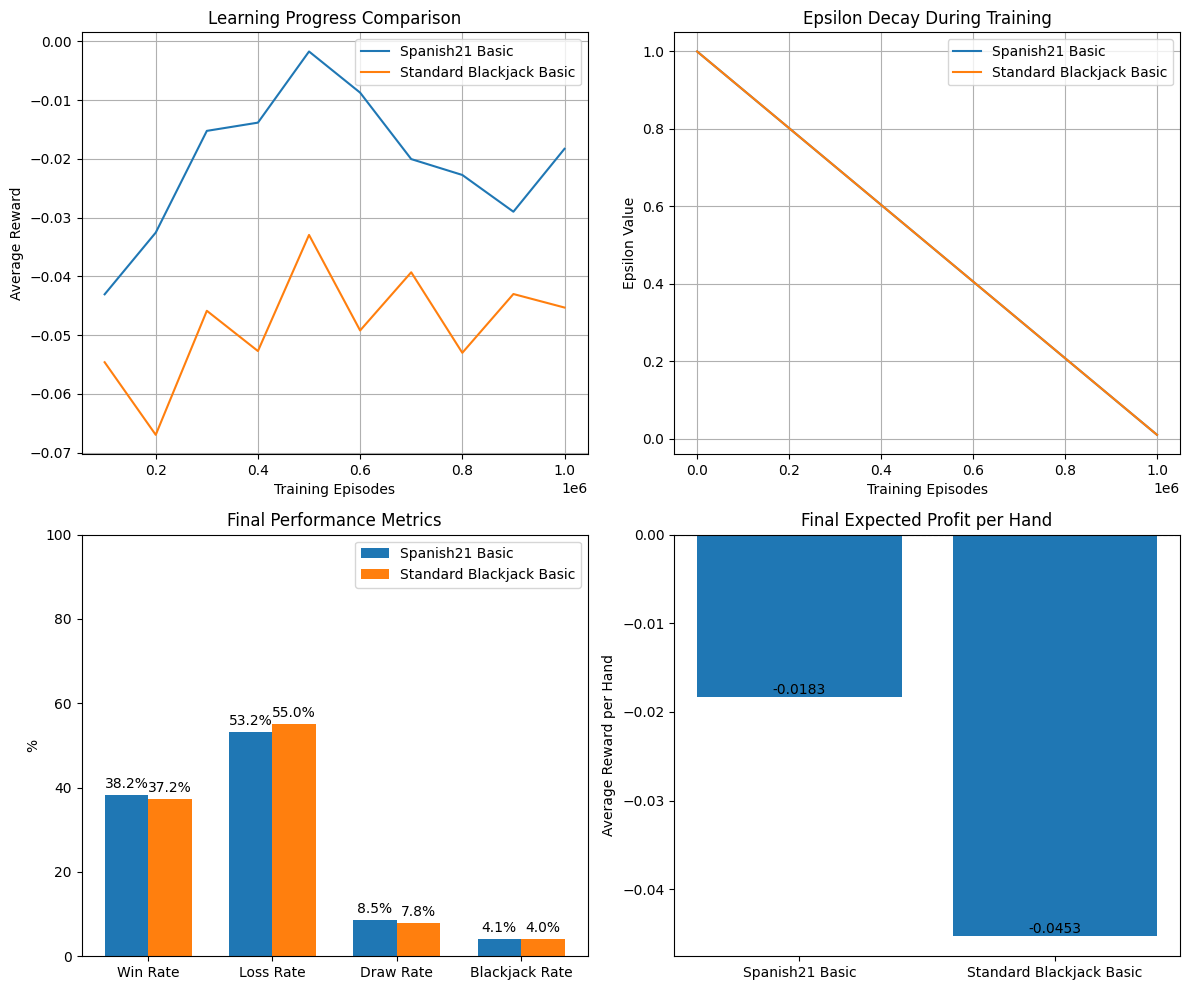

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Hyperparameters
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
EPSILON_START = 1.0
EPSILON_DECAY = 0.000001
MIN_EPSILON = 0.01

NUM_DECKS = 6
DEALER_HITS_SOFT_17 = True
BLACKJACK_PAYOUT = 1.0
ACTIONS = [0, 1, 2, 3, 4]  # Stand, Hit, Double, Split, Surrender

TRAIN_EPISODES = 1000000
EVAL_EPISODES = 100000
LOG_INTERVAL = 100000

class Spanish21Env:
    def __init__(self, num_decks=NUM_DECKS):
        self.num_decks = num_decks
        self.payout_ratio = BLACKJACK_PAYOUT
        self.dealer_hits_soft_17 = DEALER_HITS_SOFT_17
        self.can_surrender = True

        self.ranks = [str(i) for i in range(2,10)] + ['J','Q','K','A']
        self.suits = ['H','D','C','S']

        self.bonus_payouts = {
            '5_card_21': 2.0, '6_card_21': 3.0, '7_card_21': 4.0,
            '678_mixed': 3.0, '777': 3.0
        }

        self.reset_deck()

    def reset_deck(self):
        self.deck = [(r,s) for _ in range(self.num_decks)
                    for r in self.ranks for s in self.suits]
        random.shuffle(self.deck)
        self.running_count = 0
        self.cards_dealt = 0

    def _deal_card(self):
        if len(self.deck) < 15:
            self.reset_deck()
        card = self.deck.pop()
        self.cards_dealt += 1
        return card

    def _get_card_value(self, card):
        if card[0] in ['J','Q','K']: return 10
        elif card[0] == 'A': return 11
        return int(card[0])

    def _get_hand_value(self, hand):
        value, aces = 0, 0
        for card in hand:
            val = self._get_card_value(card)
            value += val
            if val == 11: aces += 1

        while value > 21 and aces > 0:
            value -= 10
            aces -= 1

        return value, (aces > 0 and value <= 21)

    def _check_bonuses(self, hand):
        val, _ = self._get_hand_value(hand)
        if len(hand) >= 5 and val == 21 and len(hand) <= 7:
            return self.bonus_payouts[f'{len(hand)}_card_21']
        if len(hand) == 3:
            ranks = sorted([c[0] for c in hand])
            if ranks == ['6','7','8']: return self.bonus_payouts['678_mixed']
            if len(set(ranks)) == 1 and ranks[0] == '7': return self.bonus_payouts['777']
        return 0

    def _play_dealer(self):
        while True:
            val, soft = self._get_hand_value(self.dealer_hand)
            if val < 17 or (val == 17 and soft and self.dealer_hits_soft_17):
                self.dealer_hand.append(self._deal_card())
            else:
                return val

    def reset(self):
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]
        self.can_surrender = True

        p_val, _ = self._get_hand_value(self.player_hand)
        d_val, _ = self._get_hand_value(self.dealer_hand)

        if p_val == 21:
            bonus = self._check_bonuses(self.player_hand)
            if d_val == 21: return self._get_state(), 0, True
            return self._get_state(), self.payout_ratio + bonus, True

        return self._get_state(), 0, False

    def _get_state(self):
        p_val, usable_ace = self._get_hand_value(self.player_hand)
        d_up = self._get_card_value(self.dealer_hand[0])

        return (
            min(p_val - 2, 19),
            min(d_up - 2, 8),
            int(usable_ace),
            int(len(self.player_hand) == 2),
            int(len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]),
            int(self.can_surrender),
            0  # Ignore count for basic strategy
        )

    def step(self, action):
        reward, done, bonus = 0, False, 0

        if action == 0:  # Stand
            dealer_val = self._play_dealer()
            p_val, _ = self._get_hand_value(self.player_hand)
            bonus = self._check_bonuses(self.player_hand)

            if p_val > 21: reward = -1
            elif dealer_val > 21: reward = 1
            elif p_val > dealer_val: reward = 1
            elif p_val < dealer_val: reward = -1
            done = True

        elif action == 1:  # Hit
            self.player_hand.append(self._deal_card())
            p_val, _ = self._get_hand_value(self.player_hand)
            if p_val > 21: reward, done = -1, True
            else: bonus = self._check_bonuses(self.player_hand)

        elif action == 2:  # Double
            if len(self.player_hand) == 2:
                self.player_hand.append(self._deal_card())
                p_val, _ = self._get_hand_value(self.player_hand)
                bonus = self._check_bonuses(self.player_hand)

                if p_val > 21: reward = -2
                else:
                    dealer_val = self._play_dealer()
                    reward = 2 if p_val > dealer_val else -2
                done = True
            else:
                reward, done = -1, True

        elif action == 3:  # Split
            if len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
                hand1 = [self.player_hand[0], self._deal_card()]
                hand2 = [self.player_hand[1], self._deal_card()]

                for hand in [hand1, hand2]:
                    while True:
                        val, _ = self._get_hand_value(hand)
                        if val >= 17: break
                        hand.append(self._deal_card())

                dealer_val = self._play_dealer()
                total = 0
                for hand in [hand1, hand2]:
                    val, _ = self._get_hand_value(hand)
                    bonus += self._check_bonuses(hand)
                    total += 1 if val > dealer_val else -1
                reward = total
                done = True
            else:
                reward, done = -1, True

        elif action == 4:  # Surrender
            if self.can_surrender: reward, done = -0.5, True
            else: reward, done = -1, True

        return self._get_state(), reward + bonus, done, {}

class BlackjackEnv(Spanish21Env):
    def __init__(self, num_decks=NUM_DECKS):
        super().__init__(num_decks)
        self.bonus_payouts = {}  # No bonuses in standard blackjack
        self.payout_ratio = 1.5  # Standard 3:2 blackjack payout
        # Override _check_bonuses to return 0 for standard blackjack
    def _check_bonuses(self, hand):
        return 0


class QLearningAgent:
    def __init__(self, actions):
        self.actions = actions
        self.alpha = LEARNING_RATE
        self.gamma = DISCOUNT_FACTOR
        self.epsilon = EPSILON_START
        self.epsilon_start = EPSILON_START # Initialize epsilon_start
        self.epsilon_decay_rate = (EPSILON_START - MIN_EPSILON) / TRAIN_EPISODES # Calculate linear decay rate
        self.min_epsilon = MIN_EPSILON
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.episode_count = 0 # Track episodes for linear decay

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        current = self.q_table[state][action]
        target = reward if done else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - current)

    def decay_epsilon(self):
        self.episode_count += 1
        self.epsilon = max(self.min_epsilon, self.epsilon_start - self.epsilon_decay_rate * self.episode_count)


def train_and_evaluate(env, strategy_name):
    agent = QLearningAgent(ACTIONS)
    rewards_history = []
    epsilon_history = [] # Store epsilon values

    print(f"Training {strategy_name} strategy...")
    for episode in range(1, TRAIN_EPISODES+1):
        state, reward, done = env.reset()
        total_reward = reward

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon) # Record epsilon after decay

        if episode % LOG_INTERVAL == 0:
            avg_reward = evaluate(env, agent, EVAL_EPISODES//10)
            rewards_history.append(avg_reward)
            print(f"Episode {episode}: Avg Reward = {avg_reward:.4f}")

    final_reward, win_rate, loss_rate, draw_rate, bj_rate = evaluate(env, agent, EVAL_EPISODES, True)
    print(f"\nFinal {strategy_name} Performance:")
    print(f"Avg Reward: {final_reward:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Blackjack Rate: {bj_rate:.2f}%")

    return {
        'rewards': rewards_history,
        'epsilon_history': epsilon_history, # Return epsilon history
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'draw_rate': draw_rate,
        'bj_rate': bj_rate
    }

def evaluate(env, agent, episodes, full_stats=False):
    rewards = []
    wins = losses = draws = blackjacks = 0

    agent.epsilon = 0.0  # Greedy evaluation

    for _ in range(episodes):
        state, reward, done = env.reset()
        total_reward = reward
        has_blackjack = (reward > 0 and done)

        while not done:
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)

        if full_stats:
            if total_reward > 0: wins += 1
            elif total_reward < 0: losses += 1
            else: draws += 1
            if has_blackjack: blackjacks += 1

    # Restore epsilon after evaluation (important if training continues)
    # Note: This evaluate function is called from train_and_evaluate,
    # which manages the agent's epsilon decay. Setting it to 0 here
    # is only for the duration of the evaluation block.
    # The calling function (train_and_evaluate) will restore the epsilon
    # to its value before evaluation started implicitly by continuing the loop.
    # No explicit restoration needed here.

    if full_stats:
        return (
            np.mean(rewards),
            wins/episodes*100,
            losses/episodes*100,
            draws/episodes*100,
            blackjacks/episodes*100
        )
    return np.mean(rewards)

def plot_comparison(results):
    strategies = list(results.keys())

    # Create a figure with more subplots for the new graphs
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Reward progression
    ax1 = axs[0, 0]
    for strat in strategies:
        # Plot average rewards collected during training
        episodes_for_plot = range(LOG_INTERVAL, TRAIN_EPISODES + LOG_INTERVAL, LOG_INTERVAL)
        ax1.plot(episodes_for_plot, results[strat]['rewards'], label=strat)
    ax1.set_xlabel("Training Episodes")
    ax1.set_ylabel("Average Reward")
    ax1.set_title("Learning Progress Comparison")
    ax1.legend()
    ax1.grid(True)

    # 2. Epsilon Decay
    ax2 = axs[0, 1]
    for strat in strategies:
        # Plot epsilon history
        ax2.plot(results[strat]['epsilon_history'], label=strat)
    ax2.set_xlabel("Training Episodes") # Epsilon history length equals total episodes
    ax2.set_ylabel("Epsilon Value")
    ax2.set_title("Epsilon Decay During Training")
    ax2.legend()
    ax2.grid(True)


    # 3. Performance metrics (Win/Loss/Draw/Blackjack Rates)
    ax3 = axs[1, 0]
    metrics = ['win_rate', 'loss_rate', 'draw_rate', 'bj_rate']
    metric_names = ['Win Rate', 'Loss Rate', 'Draw Rate', 'Blackjack Rate']

    x = np.arange(len(metric_names))
    width = 0.35
    for i, strat in enumerate(strategies):
        values = [results[strat][m] for m in metrics]
        ax3.bar(x + i*width - (len(strategies)-1)*width/2, values, width, label=strat)

    ax3.set_xticks(x)
    ax3.set_xticklabels(metric_names)
    ax3.set_ylabel("%")
    ax3.set_title("Final Performance Metrics")
    ax3.legend()
    ax3.set_ylim(0, 100)
    # Add value labels on top of bars
    for i, strat in enumerate(strategies):
        values = [results[strat][m] for m in metrics]
        for j, v in enumerate(values):
             ax3.text(x[j] + i*width - (len(strategies)-1)*width/2, v + 1, f"{v:.1f}%", ha='center', va='bottom')


    # 4. Expected Profit (Final Evaluation)
    ax4 = axs[1, 1]
    expected_profits = [results[s]['rewards'][-1] for s in strategies] # Use the last recorded avg reward
    ax4.bar(strategies, expected_profits)
    ax4.set_ylabel("Average Reward per Hand")
    ax4.set_title("Final Expected Profit per Hand")
    ax4.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    # Add value labels on top of bars
    for i, profit in enumerate(expected_profits):
        ax4.text(i, profit, f'{profit:.4f}', ha='center', va='bottom')


    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    results = {
        "Spanish21 Basic": train_and_evaluate(Spanish21Env(), "Spanish21 Basic"),
        "Standard Blackjack Basic": train_and_evaluate(BlackjackEnv(), "Standard Blackjack Basic")
    }
    plot_comparison(results)

## Spanish 21 with Point count Strategy

Training Spanish21 Count strategy...
Episode 100000: Avg Reward = -0.1062
Episode 200000: Avg Reward = -0.1111
Episode 300000: Avg Reward = -0.0606
Episode 400000: Avg Reward = -0.0379
Episode 500000: Avg Reward = -0.0544
Episode 600000: Avg Reward = -0.0566
Episode 700000: Avg Reward = -0.0486
Episode 800000: Avg Reward = -0.0342
Episode 900000: Avg Reward = -0.0449
Episode 1000000: Avg Reward = -0.0549

Final Spanish21 Count Performance:
Avg Reward: -0.0406
Win Rate: 38.43%
Loss Rate: 53.23%
Draw Rate: 8.34%
Blackjack Rate: 4.10%
Training Standard Blackjack Count strategy...
Episode 100000: Avg Reward = -0.1168
Episode 200000: Avg Reward = -0.0675
Episode 300000: Avg Reward = -0.0798
Episode 400000: Avg Reward = -0.0741
Episode 500000: Avg Reward = -0.0663
Episode 600000: Avg Reward = -0.0683
Episode 700000: Avg Reward = -0.0628
Episode 800000: Avg Reward = -0.0657
Episode 900000: Avg Reward = -0.0592
Episode 1000000: Avg Reward = -0.0556

Final Standard Blackjack Count Performance:


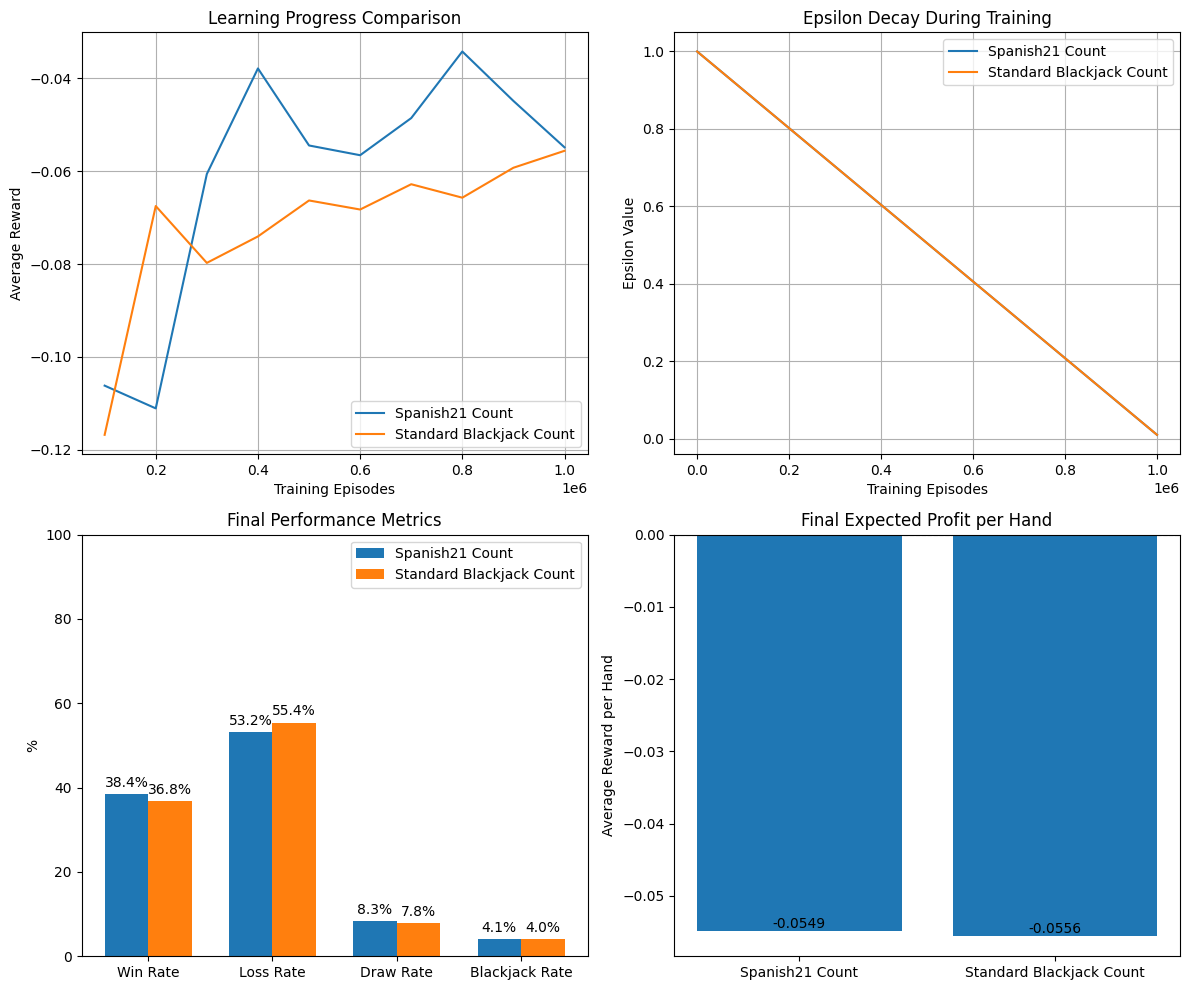

In [ ]:
class Spanish21Env:
    def __init__(self, num_decks=NUM_DECKS):
        self.num_decks = num_decks
        self.payout_ratio = BLACKJACK_PAYOUT
        self.dealer_hits_soft_17 = DEALER_HITS_SOFT_17
        self.can_surrender = True

        self.ranks = [str(i) for i in range(2,10)] + ['J','Q','K','A']
        self.suits = ['H','D','C','S']

        self.bonus_payouts = {
            '5_card_21': 2.0, '6_card_21': 3.0, '7_card_21': 4.0,
            '678_mixed': 3.0, '777': 3.0
        }

        self.reset_deck()

    def reset_deck(self):
        self.deck = [(r,s) for _ in range(self.num_decks)
                    for r in self.ranks for s in self.suits]
        random.shuffle(self.deck)
        self.running_count = 0
        self.cards_dealt = 0

    def _deal_card(self):
        if len(self.deck) < 15:
            self.reset_deck()
        card = self.deck.pop()
        self.cards_dealt += 1
        # Spanish 21 count: +1 for 2-7, -1 for A,K,Q,J,9
        if card[0] in ['2','3','4','5','6','7']:
            self.running_count += 1
        elif card[0] in ['9','J','Q','K','A']:
            self.running_count -= 1
        return card

    def _get_card_value(self, card):
        if card[0] in ['J','Q','K']: return 10
        elif card[0] == 'A': return 11
        return int(card[0])

    def _get_hand_value(self, hand):
        value, aces = 0, 0
        for card in hand:
            val = self._get_card_value(card)
            value += val
            if val == 11: aces += 1

        while value > 21 and aces > 0:
            value -= 10
            aces -= 1

        return value, (aces > 0 and value <= 21)

    def _check_bonuses(self, hand):
        val, _ = self._get_hand_value(hand)
        if len(hand) >= 5 and val == 21 and len(hand) <= 7:
            return self.bonus_payouts[f'{len(hand)}_card_21']
        if len(hand) == 3:
            ranks = sorted([c[0] for c in hand])
            if ranks == ['6','7','8']: return self.bonus_payouts['678_mixed']
            if len(set(ranks)) == 1 and ranks[0] == '7': return self.bonus_payouts['777']
        return 0

    def _play_dealer(self):
        while True:
            val, soft = self._get_hand_value(self.dealer_hand)
            if val < 17 or (val == 17 and soft and self.dealer_hits_soft_17):
                self.dealer_hand.append(self._deal_card())
            else:
                return val

    def reset(self):
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]
        self.can_surrender = True

        p_val, _ = self._get_hand_value(self.player_hand)
        d_val, _ = self._get_hand_value(self.dealer_hand)

        if p_val == 21:
            bonus = self._check_bonuses(self.player_hand)
            if d_val == 21: return self._get_state(), 0, True
            return self._get_state(), self.payout_ratio + bonus, True

        return self._get_state(), 0, False

    def _get_state(self):
        p_val, usable_ace = self._get_hand_value(self.player_hand)
        d_up = self._get_card_value(self.dealer_hand[0])

        true_count = self.running_count / max(1, (self.num_decks*48 - self.cards_dealt)/48)
        count_idx = 0
        if true_count < -2: count_idx = 0
        elif true_count < -1: count_idx = 1
        elif true_count < 0: count_idx = 2
        elif true_count < 1: count_idx = 3
        elif true_count < 2: count_idx = 4
        elif true_count < 3: count_idx = 5
        else: count_idx = 6

        return (
            min(p_val - 2, 19),
            min(d_up - 2, 8),
            int(usable_ace),
            int(len(self.player_hand) == 2),
            int(len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]),
            int(self.can_surrender),
            count_idx
        )

    def step(self, action):
        reward, done, bonus = 0, False, 0

        if action == 0:  # Stand
            dealer_val = self._play_dealer()
            p_val, _ = self._get_hand_value(self.player_hand)
            bonus = self._check_bonuses(self.player_hand)

            if p_val > 21: reward = -1
            elif dealer_val > 21: reward = 1
            elif p_val > dealer_val: reward = 1
            elif p_val < dealer_val: reward = -1
            done = True

        elif action == 1:  # Hit
            self.player_hand.append(self._deal_card())
            p_val, _ = self._get_hand_value(self.player_hand)
            if p_val > 21: reward, done = -1, True
            else: bonus = self._check_bonuses(self.player_hand)

        elif action == 2:  # Double
            if len(self.player_hand) == 2:
                self.player_hand.append(self._deal_card())
                p_val, _ = self._get_hand_value(self.player_hand)
                bonus = self._check_bonuses(self.player_hand)

                if p_val > 21: reward = -2
                else:
                    dealer_val = self._play_dealer()
                    reward = 2 if p_val > dealer_val else -2
                done = True
            else:
                reward, done = -1, True

        elif action == 3:  # Split
            if len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
                hand1 = [self.player_hand[0], self._deal_card()]
                hand2 = [self.player_hand[1], self._deal_card()]

                for hand in [hand1, hand2]:
                    while True:
                        val, _ = self._get_hand_value(hand)
                        if val >= 17: break
                        hand.append(self._deal_card())

                dealer_val = self._play_dealer()
                total = 0
                for hand in [hand1, hand2]:
                    val, _ = self._get_hand_value(hand)
                    bonus += self._check_bonuses(hand)
                    total += 1 if val > dealer_val else -1
                reward = total
                done = True
            else:
                reward, done = -1, True

        elif action == 4:  # Surrender
            if self.can_surrender: reward, done = -0.5, True
            else: reward, done = -1, True

        return self._get_state(), reward + bonus, done, {}

class BlackjackEnv(Spanish21Env):
    def __init__(self, num_decks=NUM_DECKS):
        super().__init__(num_decks)
        self.bonus_payouts = {}  # No bonuses in standard blackjack
        self.payout_ratio = 1.5  # Standard 3:2 blackjack payout

    def _deal_card(self):
        if len(self.deck) < 15:
            self.reset_deck()
        card = self.deck.pop()
        self.cards_dealt += 1
        # Hi-Lo count system
        if card[0] in ['2','3','4','5','6']: self.running_count += 1
        elif card[0] in ['10','J','Q','K','A']: self.running_count -= 1
        return card

    # Override _check_bonuses to return 0 for standard blackjack
    def _check_bonuses(self, hand):
        return 0


class QLearningAgent:
    def __init__(self, actions):
        self.actions = actions
        self.alpha = LEARNING_RATE
        self.gamma = DISCOUNT_FACTOR
        self.epsilon = EPSILON_START
        self.epsilon_start = EPSILON_START # Initialize epsilon_start
        self.epsilon_decay_rate = (EPSILON_START - MIN_EPSILON) / TRAIN_EPISODES # Calculate linear decay rate
        self.min_epsilon = MIN_EPSILON
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.episode_count = 0 # Track episodes for linear decay

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        current = self.q_table[state][action]
        target = reward if done else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - current)

    def decay_epsilon(self):
        self.episode_count += 1
        self.epsilon = max(self.min_epsilon, self.epsilon_start - self.epsilon_decay_rate * self.episode_count)

def train_and_evaluate(env, strategy_name):
    agent = QLearningAgent(ACTIONS)
    rewards_history = []
    epsilon_history = [] # Store epsilon values

    print(f"Training {strategy_name} strategy...")
    for episode in range(1, TRAIN_EPISODES+1):
        state, reward, done = env.reset()
        total_reward = reward

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon) # Record epsilon after decay

        if episode % LOG_INTERVAL == 0:
            avg_reward = evaluate(env, agent, EVAL_EPISODES//10)
            rewards_history.append(avg_reward)
            print(f"Episode {episode}: Avg Reward = {avg_reward:.4f}")

    final_reward, win_rate, loss_rate, draw_rate, bj_rate = evaluate(env, agent, EVAL_EPISODES, True)
    print(f"\nFinal {strategy_name} Performance:")
    print(f"Avg Reward: {final_reward:.4f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Loss Rate: {loss_rate:.2f}%")
    print(f"Draw Rate: {draw_rate:.2f}%")
    print(f"Blackjack Rate: {bj_rate:.2f}%")

    return {
        'rewards': rewards_history,
        'epsilon_history': epsilon_history, # Return epsilon history
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'draw_rate': draw_rate,
        'bj_rate': bj_rate
    }

def evaluate(env, agent, episodes, full_stats=False):
    rewards = []
    wins = losses = draws = blackjacks = 0

    agent.epsilon = 0.0  # Greedy evaluation

    for _ in range(episodes):
        state, reward, done = env.reset()
        total_reward = reward
        has_blackjack = (reward > 0 and done)

        while not done:
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward

        rewards.append(total_reward)

        if full_stats:
            if total_reward > 0: wins += 1
            elif total_reward < 0: losses += 1
            else: draws += 1
            if has_blackjack: blackjacks += 1

    # Restore epsilon after evaluation (important if training continues)
    # Note: This evaluate function is called from train_and_evaluate,
    # which manages the agent's epsilon decay. Setting it to 0 here
    # is only for the duration of the evaluation block.
    # The calling function (train_and_evaluate) will restore the epsilon
    # to its value before evaluation started implicitly by continuing the loop.
    # No explicit restoration needed here.

    if full_stats:
        return (
            np.mean(rewards),
            wins/episodes*100,
            losses/episodes*100,
            draws/episodes*100,
            blackjacks/episodes*100
        )
    return np.mean(rewards)

def plot_comparison(results):
    strategies = list(results.keys())

    # Create a figure with more subplots for the new graphs
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Reward progression
    ax1 = axs[0, 0]
    for strat in strategies:
        # Plot average rewards collected during training
        episodes_for_plot = range(LOG_INTERVAL, TRAIN_EPISODES + LOG_INTERVAL, LOG_INTERVAL)
        ax1.plot(episodes_for_plot, results[strat]['rewards'], label=strat)
    ax1.set_xlabel("Training Episodes")
    ax1.set_ylabel("Average Reward")
    ax1.set_title("Learning Progress Comparison")
    ax1.legend()
    ax1.grid(True)

    # 2. Epsilon Decay
    ax2 = axs[0, 1]
    for strat in strategies:
        # Plot epsilon history
        ax2.plot(results[strat]['epsilon_history'], label=strat)
    ax2.set_xlabel("Training Episodes") # Epsilon history length equals total episodes
    ax2.set_ylabel("Epsilon Value")
    ax2.set_title("Epsilon Decay During Training")
    ax2.legend()
    ax2.grid(True)


    # 3. Performance metrics (Win/Loss/Draw/Blackjack Rates)
    ax3 = axs[1, 0]
    metrics = ['win_rate', 'loss_rate', 'draw_rate', 'bj_rate']
    metric_names = ['Win Rate', 'Loss Rate', 'Draw Rate', 'Blackjack Rate']

    x = np.arange(len(metric_names))
    width = 0.35
    for i, strat in enumerate(strategies):
        values = [results[strat][m] for m in metrics]
        ax3.bar(x + i*width - (len(strategies)-1)*width/2, values, width, label=strat)

    ax3.set_xticks(x)
    ax3.set_xticklabels(metric_names)
    ax3.set_ylabel("%")
    ax3.set_title("Final Performance Metrics")
    ax3.legend()
    ax3.set_ylim(0, 100)
    # Add value labels on top of bars
    for i, strat in enumerate(strategies):
        values = [results[strat][m] for m in metrics]
        for j, v in enumerate(values):
             ax3.text(x[j] + i*width - (len(strategies)-1)*width/2, v + 1, f"{v:.1f}%", ha='center', va='bottom')


    # 4. Expected Profit (Final Evaluation)
    ax4 = axs[1, 1]
    expected_profits = [results[s]['rewards'][-1] for s in strategies] # Use the last recorded avg reward
    ax4.bar(strategies, expected_profits)
    ax4.set_ylabel("Average Reward per Hand")
    ax4.set_title("Final Expected Profit per Hand")
    ax4.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    # Add value labels on top of bars
    for i, profit in enumerate(expected_profits):
        ax4.text(i, profit, f'{profit:.4f}', ha='center', va='bottom')


    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    results = {
        "Spanish21 Count": train_and_evaluate(Spanish21Env(), "Spanish21 Count"),
        "Standard Blackjack Count": train_and_evaluate(BlackjackEnv(), "Standard Blackjack Count")
    }
    plot_comparison(results)

## Late Surrender with Basic Strategy

Training with surrender...
Episode 50000/1000000, Epsilon: 0.9500, Avg Reward (last evaluation): -0.0495
Episode 100000/1000000, Epsilon: 0.9000, Avg Reward (last evaluation): -0.0430
Episode 150000/1000000, Epsilon: 0.8500, Avg Reward (last evaluation): -0.0368
Episode 200000/1000000, Epsilon: 0.8000, Avg Reward (last evaluation): -0.0396
Episode 250000/1000000, Epsilon: 0.7500, Avg Reward (last evaluation): -0.0249
Episode 300000/1000000, Epsilon: 0.7000, Avg Reward (last evaluation): -0.0346
Episode 350000/1000000, Epsilon: 0.6500, Avg Reward (last evaluation): -0.0454
Episode 400000/1000000, Epsilon: 0.6000, Avg Reward (last evaluation): -0.0443
Episode 450000/1000000, Epsilon: 0.5500, Avg Reward (last evaluation): -0.0433
Episode 500000/1000000, Epsilon: 0.5000, Avg Reward (last evaluation): -0.0187
Episode 550000/1000000, Epsilon: 0.4500, Avg Reward (last evaluation): -0.0378
Episode 600000/1000000, Epsilon: 0.4000, Avg Reward (last evaluation): -0.0248
Episode 650000/1000000, Ep

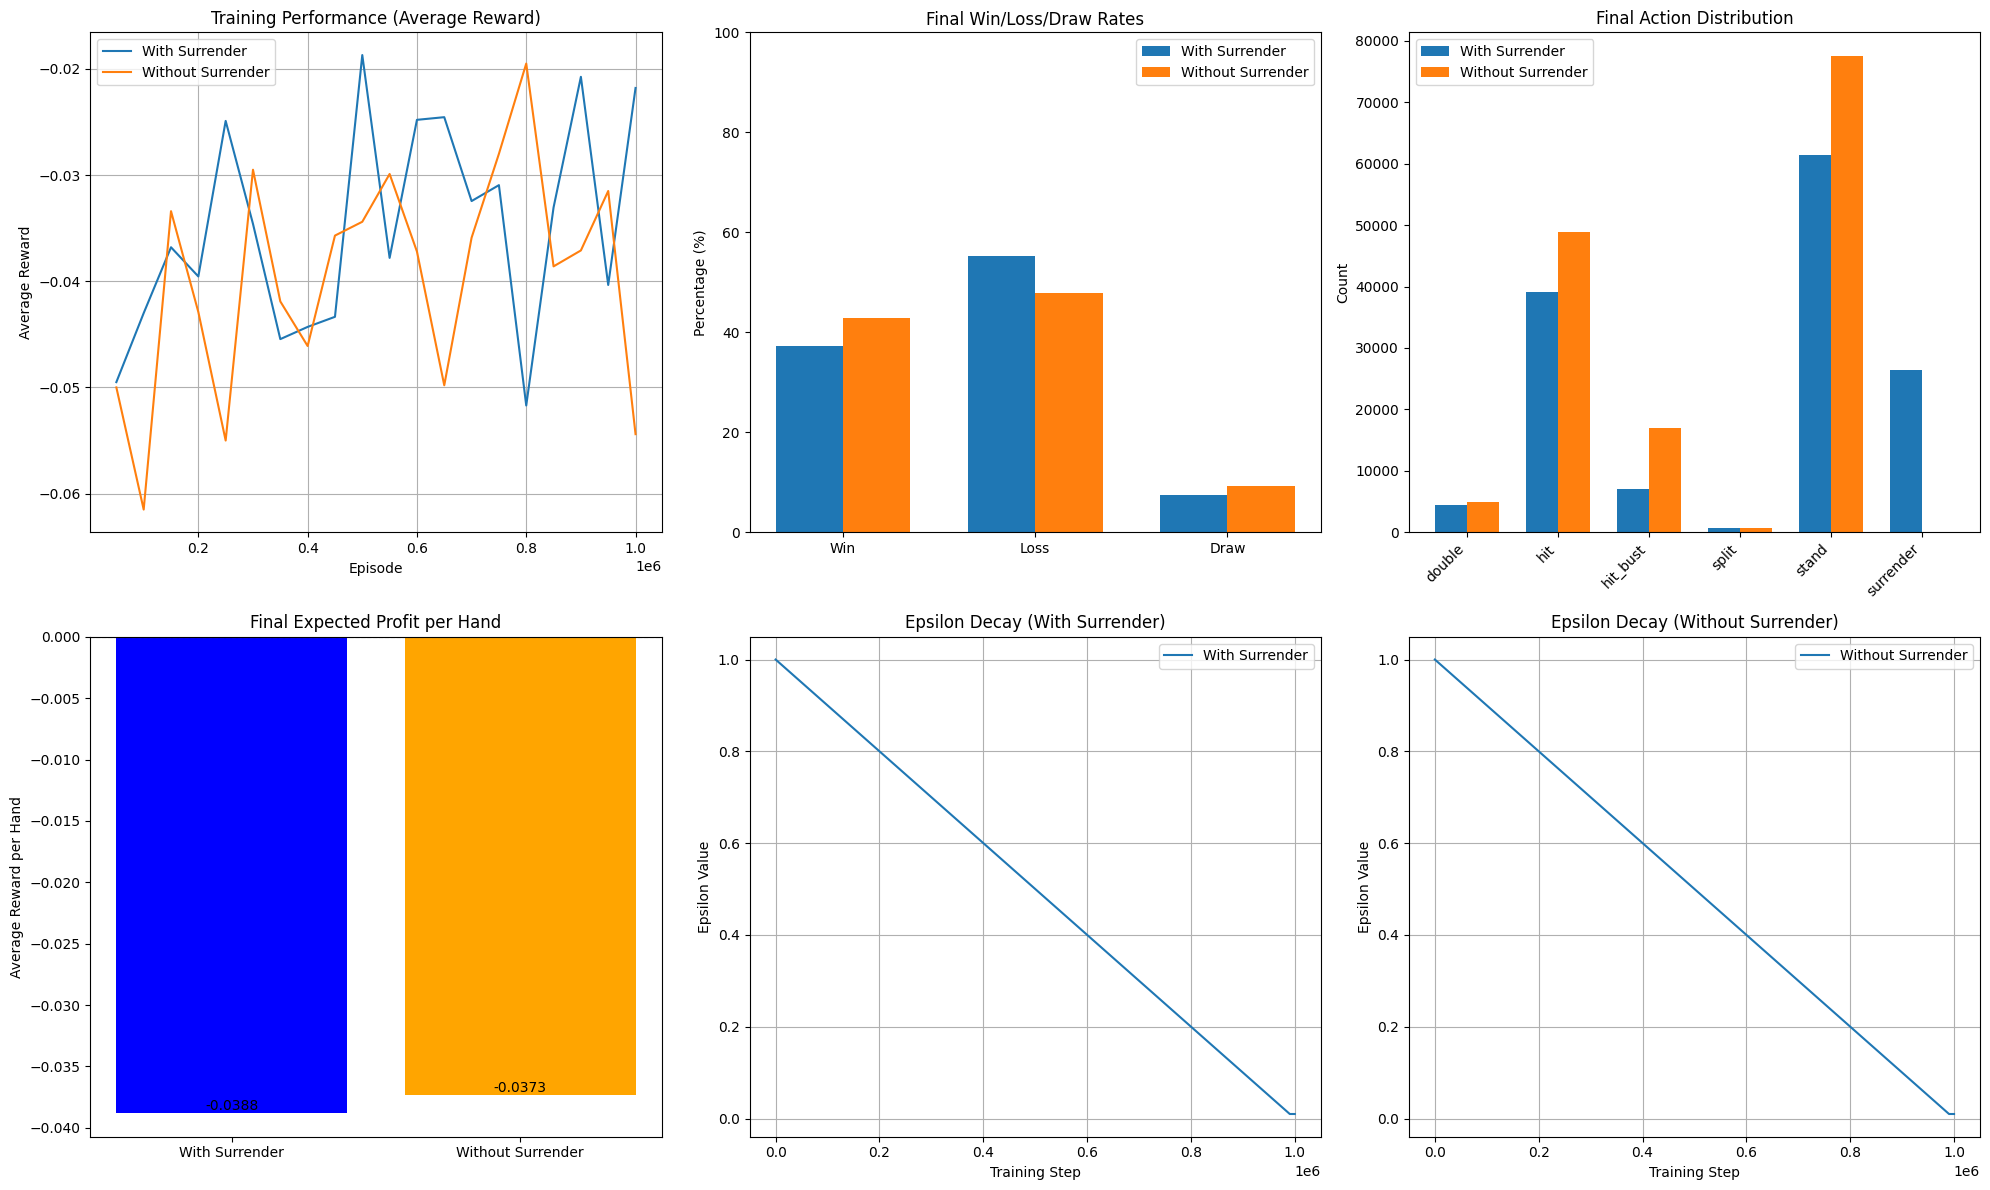

In [ ]:
import random
import numpy as np
import collections
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

class BlackjackEnv:
    def __init__(self, num_decks=6, dealer_hits_soft_17=False, allow_late_surrender=True):
        self.num_decks = num_decks
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.allow_late_surrender = allow_late_surrender
        self.reset()

    def reset(self):
        ranks = [str(i) for i in range(2,11)] + ['J','Q','K','A']
        suits = ['H','D','C','S']
        self.deck = [(r,s) for _ in range(self.num_decks) for r in ranks for s in suits]
        random.shuffle(self.deck)
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]
        self.can_surrender = self.allow_late_surrender and len(self.player_hand) == 2
        return self._get_state()

    def _deal_card(self):
        return self.deck.pop()

    def _get_hand_value(self, hand):
        value, aces = 0, 0
        for card in hand:
            val = 11 if card[0] == 'A' else 10 if card[0] in ['J','Q','K'] else int(card[0])
            value += val
            aces += 1 if val == 11 else 0
        while value > 21 and aces > 0:
            value -= 10
            aces -= 1
        return value, aces > 0

    def _get_state(self):
        player_value, usable_ace = self._get_hand_value(self.player_hand)
        dealer_up = self._get_card_value(self.dealer_hand[0])
        can_double = len(self.player_hand) == 2
        can_split = len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]
        return (player_value, dealer_up, int(usable_ace), int(can_double), int(can_split), int(self.can_surrender))

    def _get_card_value(self, card):
        return 11 if card[0] == 'A' else 10 if card[0] in ['J','Q','K'] else int(card[0])

    def step(self, action):
        if action == 4 and self.can_surrender:  # Surrender
            return None, -0.5, True, {'action':'surrender'}

        if action == 0:  # Stand
            dealer_value = self._play_dealer()
            player_value, _ = self._get_hand_value(self.player_hand)
            reward = self._resolve_hand(player_value, dealer_value)
            return None, reward, True, {'action':'stand', 'dealer_value':dealer_value}

        elif action == 1:  # Hit
            self.player_hand.append(self._deal_card())
            player_value, _ = self._get_hand_value(self.player_hand)
            if player_value > 21:
                return None, -1, True, {'action':'hit_bust'}
            return self._get_state(), 0, False, {'action':'hit'}

        elif action == 2:  # Double
            if len(self.player_hand) == 2:
                self.player_hand.append(self._deal_card())
                player_value, _ = self._get_hand_value(self.player_hand)
                if player_value > 21:
                    return None, -2, True, {'action':'double_bust'}
                dealer_value = self._play_dealer()
                reward = self._resolve_hand(player_value, dealer_value) * 2
                return None, reward, True, {'action':'double', 'dealer_value':dealer_value}
            return None, -1, True, {'action':'invalid_double'}

        elif action == 3:  # Split
            if len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
                hand1 = [self.player_hand[0], self._deal_card()]
                hand2 = [self.player_hand[1], self._deal_card()]
                dealer_value = self._play_dealer()
                total = 0
                for hand in [hand1, hand2]:
                    val, _ = self._get_hand_value(hand)
                    total += self._resolve_hand(val, dealer_value)
                return None, total, True, {'action':'split', 'dealer_value':dealer_value}
            return None, -1, True, {'action':'invalid_split'}

    def _play_dealer(self):
        while True:
            val, soft = self._get_hand_value(self.dealer_hand)
            if val < 17 or (val == 17 and soft and self.dealer_hits_soft_17):
                self.dealer_hand.append(self._deal_card())
            else:
                return val

    def _resolve_hand(self, player_value, dealer_value):
        if player_value > 21:
            return -1
        if dealer_value > 21:
            return 1
        if player_value > dealer_value:
            return 1
        if player_value < dealer_value:
            return -1
        return 0

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.01, discount_factor=0.99, epsilon_start=1.0, epsilon_decay=0.000001, min_epsilon=0.01):
        self.actions = actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))
        self.epsilon_history = []  # Track epsilon values over time

    def get_action(self, state):
        if random.random() < self.epsilon:
            # Ensure exploration chooses from valid actions
            player_value, dealer_up, usable_ace, can_double, can_split, can_surrender = state
            valid_actions = [0, 1] # Stand and Hit are always valid
            if can_double: valid_actions.append(2)
            if can_split: valid_actions.append(3)
            if can_surrender: valid_actions.append(4)
            return random.choice(valid_actions)

        # Ensure exploitation chooses from valid actions
        player_value, dealer_up, usable_ace, can_double, can_split, can_surrender = state
        valid_actions_mask = np.zeros(len(self.actions), dtype=bool)
        valid_actions_mask[0] = True # Stand
        valid_actions_mask[1] = True # Hit
        if can_double: valid_actions_mask[2] = True
        if can_split: valid_actions_mask[3] = True
        if can_surrender: valid_actions_mask[4] = True

        masked_q_values = np.where(valid_actions_mask, self.q_table[state], -np.inf)
        # Handle case where all valid actions have the same Q value (e.g., all zero initially)
        if np.all(masked_q_values == -np.inf):
            # Fallback to random valid action if no valid actions or all masked out
            player_value, dealer_up, usable_ace, can_double, can_split, can_surrender = state
            valid_actions = [0, 1] # Stand and Hit are always valid
            if can_double: valid_actions.append(2)
            if can_split: valid_actions.append(3)
            if can_surrender: valid_actions.append(4)
            return random.choice(valid_actions)
        return np.argmax(masked_q_values)

    def learn(self, state, action, reward, next_state, done):
        current = self.q_table[state][action]
        if done:
            target = reward
        else:
            # Q-learning uses the max Q value of the next state
            # Need to mask invalid actions for the next state when calculating max Q
            _, _, next_usable_ace, next_can_double, next_can_split, next_can_surrender = next_state
            next_valid_actions_mask = np.zeros(len(self.actions), dtype=bool)
            next_valid_actions_mask[0] = True # Stand
            next_valid_actions_mask[1] = True # Hit
            if next_can_double: next_valid_actions_mask[2] = True
            if next_can_split: next_valid_actions_mask[3] = True
            if next_can_surrender: next_valid_actions_mask[4] = True # Surrender only valid on initial hand

            masked_next_q_values = np.where(next_valid_actions_mask, self.q_table[next_state], -np.inf)

            # Handle case where all valid Q values for the next state are -inf (shouldn't happen if not done)
            max_next_q = np.max(masked_next_q_values) if np.any(next_valid_actions_mask) else 0

            target = reward + self.gamma * max_next_q

        self.q_table[state][action] += self.alpha * (target - current)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)
        self.epsilon_history.append(self.epsilon)  # Record epsilon after each decay

def train_agent(env, agent, num_episodes=1000000, log_interval=10000):
    """Train the agent with periodic logging and return rewards history."""
    rewards_history = []
    episode_history = []

    for episode in range(1, num_episodes+1):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        agent.decay_epsilon()

        if episode % log_interval == 0:
            # Evaluate the current greedy policy periodically
            eval_results = evaluate(env, agent, num_episodes=10000, silent=True)
            avg_reward = eval_results['expected_profit']
            rewards_history.append(avg_reward)
            episode_history.append(episode)
            print(f"Episode {episode}/{num_episodes}, Epsilon: {agent.epsilon:.4f}, Avg Reward (last evaluation): {avg_reward:.4f}")

    return rewards_history, episode_history

def evaluate(env, agent, num_episodes, silent=False):
    total_reward = 0
    wins = losses = draws = 0
    action_counts = collections.defaultdict(int)
    surrender_count = 0

    original_epsilon = agent.epsilon # Store original epsilon
    agent.epsilon = 0.0  # Greedy evaluation

    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            state = next_state
            episode_reward += reward
            action_counts[info['action']] += 1

            if info['action'] == 'surrender':
                surrender_count += 1

        total_reward += episode_reward

        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            draws += 1

    agent.epsilon = original_epsilon # Restore epsilon

    metrics = {
        'expected_profit': total_reward / num_episodes,
        'win_rate': wins / num_episodes * 100,
        'loss_rate': losses / num_episodes * 100,
        'draw_rate': draws / num_episodes * 100,
        'surrender_rate': surrender_count / num_episodes * 100,
        'action_distribution': action_counts
    }

    if not silent:
        print(f"\nEvaluation Results over {num_episodes} episodes:")
        print(f"Expected profit per hand: {metrics['expected_profit']:.4f}")
        print(f"Win rate: {metrics['win_rate']:.2f}%")
        print(f"Loss rate: {metrics['loss_rate']:.2f}%")
        print(f"Draw rate: {metrics['draw_rate']:.2f}%")
        print(f"Surrender rate: {metrics['surrender_rate']:.2f}%")
        print("Action distribution:", dict(metrics['action_distribution']))

    return metrics

def plot_results(with_surrender_metrics, without_surrender_metrics,
                 train_history_with, train_history_without,
                 agent_with, agent_without):
    plt.figure(figsize=(20, 12))

    # 1. Training Performance (Average Reward over time)
    plt.subplot(2, 3, 1)
    plt.plot(train_history_with[1], train_history_with[0], label='With Surrender')
    plt.plot(train_history_without[1], train_history_without[0], label='Without Surrender')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Training Performance (Average Reward)')
    plt.legend()
    plt.grid(True)

    # 2. Win/Loss/Draw Rates
    plt.subplot(2, 3, 2)
    categories = ['Win', 'Loss', 'Draw']
    with_rates = [with_surrender_metrics['win_rate'],
                 with_surrender_metrics['loss_rate'],
                 with_surrender_metrics['draw_rate']]
    without_rates = [without_surrender_metrics['win_rate'],
                    without_surrender_metrics['loss_rate'],
                    without_surrender_metrics['draw_rate']]

    x = np.arange(len(categories))
    width = 0.35
    plt.bar(x - width/2, with_rates, width, label='With Surrender')
    plt.bar(x + width/2, without_rates, width, label='Without Surrender')
    plt.xticks(x, categories)
    plt.ylabel('Percentage (%)')
    plt.title('Final Win/Loss/Draw Rates')
    plt.legend()
    plt.ylim(0, 100) # Ensure y-axis goes up to 100%

    # 3. Action Distribution
    plt.subplot(2, 3, 3)
    with_actions = with_surrender_metrics['action_distribution']
    without_actions = without_surrender_metrics['action_distribution']

    actions = list(set(list(with_actions.keys()) + list(without_actions.keys())))
    # Sort actions alphabetically for consistent plotting order
    actions.sort()

    with_counts = [with_actions.get(a, 0) for a in actions]
    without_counts = [without_actions.get(a, 0) for a in actions]

    x = np.arange(len(actions))
    width = 0.35
    plt.bar(x - width/2, with_counts, width, label='With Surrender')
    plt.bar(x + width/2, without_counts, width, label='Without Surrender')
    plt.xticks(x, actions, rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('Final Action Distribution')
    plt.legend()

    # 4. Expected Profit Comparison
    plt.subplot(2, 3, 4)
    plt.bar(['With Surrender', 'Without Surrender'],
            [with_surrender_metrics['expected_profit'], without_surrender_metrics['expected_profit']],
            color=['blue', 'orange']) # Assign distinct colors
    plt.ylabel('Average Reward per Hand')
    plt.title('Final Expected Profit per Hand')
    # Add value labels on top of bars
    for i, profit in enumerate([with_surrender_metrics['expected_profit'], without_surrender_metrics['expected_profit']]):
        plt.text(i, profit, f'{profit:.4f}', ha='center', va='bottom')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at 0 for reference

    # 5. Epsilon Decay Over Time (With Surrender)
    plt.subplot(2, 3, 5)
    plt.plot(range(len(agent_with.epsilon_history)), agent_with.epsilon_history, label='With Surrender')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay (With Surrender)')
    plt.legend()
    plt.grid(True)

    # 6. Epsilon Decay Over Time (Without Surrender)
    plt.subplot(2, 3, 6)
    plt.plot(range(len(agent_without.epsilon_history)), agent_without.epsilon_history, label='Without Surrender')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay (Without Surrender)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Training parameters
    num_train_episodes = 1000000
    num_eval_episodes = 100000
    log_interval = 50000 # Log training progress every 10000 episodes

    # With Late Surrender
    env_surrender = BlackjackEnv(allow_late_surrender=True)
    agent_surrender = QLearningAgent(actions=[0,1,2,3,4])
    print("Training with surrender...")
    train_history_surrender, episode_history_surrender = train_agent(env_surrender, agent_surrender, num_train_episodes, log_interval)
    print("Evaluating with surrender...")
    metrics_surrender = evaluate(env_surrender, agent_surrender, num_eval_episodes)

    # Without Late Surrender
    env_no_surrender = BlackjackEnv(allow_late_surrender=False)
    agent_no_surrender = QLearningAgent(actions=[0,1,2,3])
    print("\nTraining without surrender...")
    train_history_no_surrender, episode_history_no_surrender = train_agent(env_no_surrender, agent_no_surrender, num_train_episodes, log_interval)
    print("Evaluating without surrender...")
    metrics_no_surrender = evaluate(env_no_surrender, agent_no_surrender, num_eval_episodes)

    # Print results
    print("\nResults with surrender:")
    print(f"Expected profit per hand: {metrics_surrender['expected_profit']:.4f}")
    print(f"Win rate: {metrics_surrender['win_rate']:.2f}%")
    print(f"Loss rate: {metrics_surrender['loss_rate']:.2f}%")
    print(f"Draw rate: {metrics_surrender['draw_rate']:.2f}%")
    print(f"Surrender rate: {metrics_surrender['surrender_rate']:.2f}%")
    print("Action distribution:", dict(metrics_surrender['action_distribution']))

    print("\nResults without surrender:")
    print(f"Expected profit per hand: {metrics_no_surrender['expected_profit']:.4f}")
    print(f"Win rate: {metrics_no_surrender['win_rate']:.2f}%")
    print(f"Loss rate: {metrics_no_surrender['loss_rate']:.2f}%")
    print(f"Draw rate: {metrics_no_surrender['draw_rate']:.2f}%")
    print("Action distribution:", dict(metrics_no_surrender['action_distribution']))

    # Plot results
    plot_results(metrics_surrender, metrics_no_surrender,
                 (train_history_surrender, episode_history_surrender),
                 (train_history_no_surrender, episode_history_no_surrender),
                 agent_surrender, agent_no_surrender)

## Late Surrender with Point count Strategy

Training with Late surrender and point counting...
Episode 50000: Avg Reward = -0.0454
Episode 100000: Avg Reward = -0.0449
Episode 150000: Avg Reward = -0.0262
Episode 200000: Avg Reward = -0.0301
Episode 250000: Avg Reward = -0.0062
Episode 300000: Avg Reward = -0.0286
Episode 350000: Avg Reward = -0.0192
Episode 400000: Avg Reward = -0.0126
Episode 450000: Avg Reward = -0.0049
Episode 500000: Avg Reward = -0.0177
Episode 550000: Avg Reward = -0.0131
Episode 600000: Avg Reward = 0.0032
Episode 650000: Avg Reward = -0.0052
Episode 700000: Avg Reward = -0.0262
Episode 750000: Avg Reward = -0.0428
Episode 800000: Avg Reward = -0.0171
Episode 850000: Avg Reward = -0.0318
Episode 900000: Avg Reward = -0.0108
Episode 950000: Avg Reward = -0.0074
Episode 1000000: Avg Reward = -0.0285
Evaluating with surrender and counting...

Training without Late surrender...
Episode 50000: Avg Reward = -0.0419
Episode 100000: Avg Reward = -0.0546
Episode 150000: Avg Reward = -0.0191
Episode 200000: Avg Re

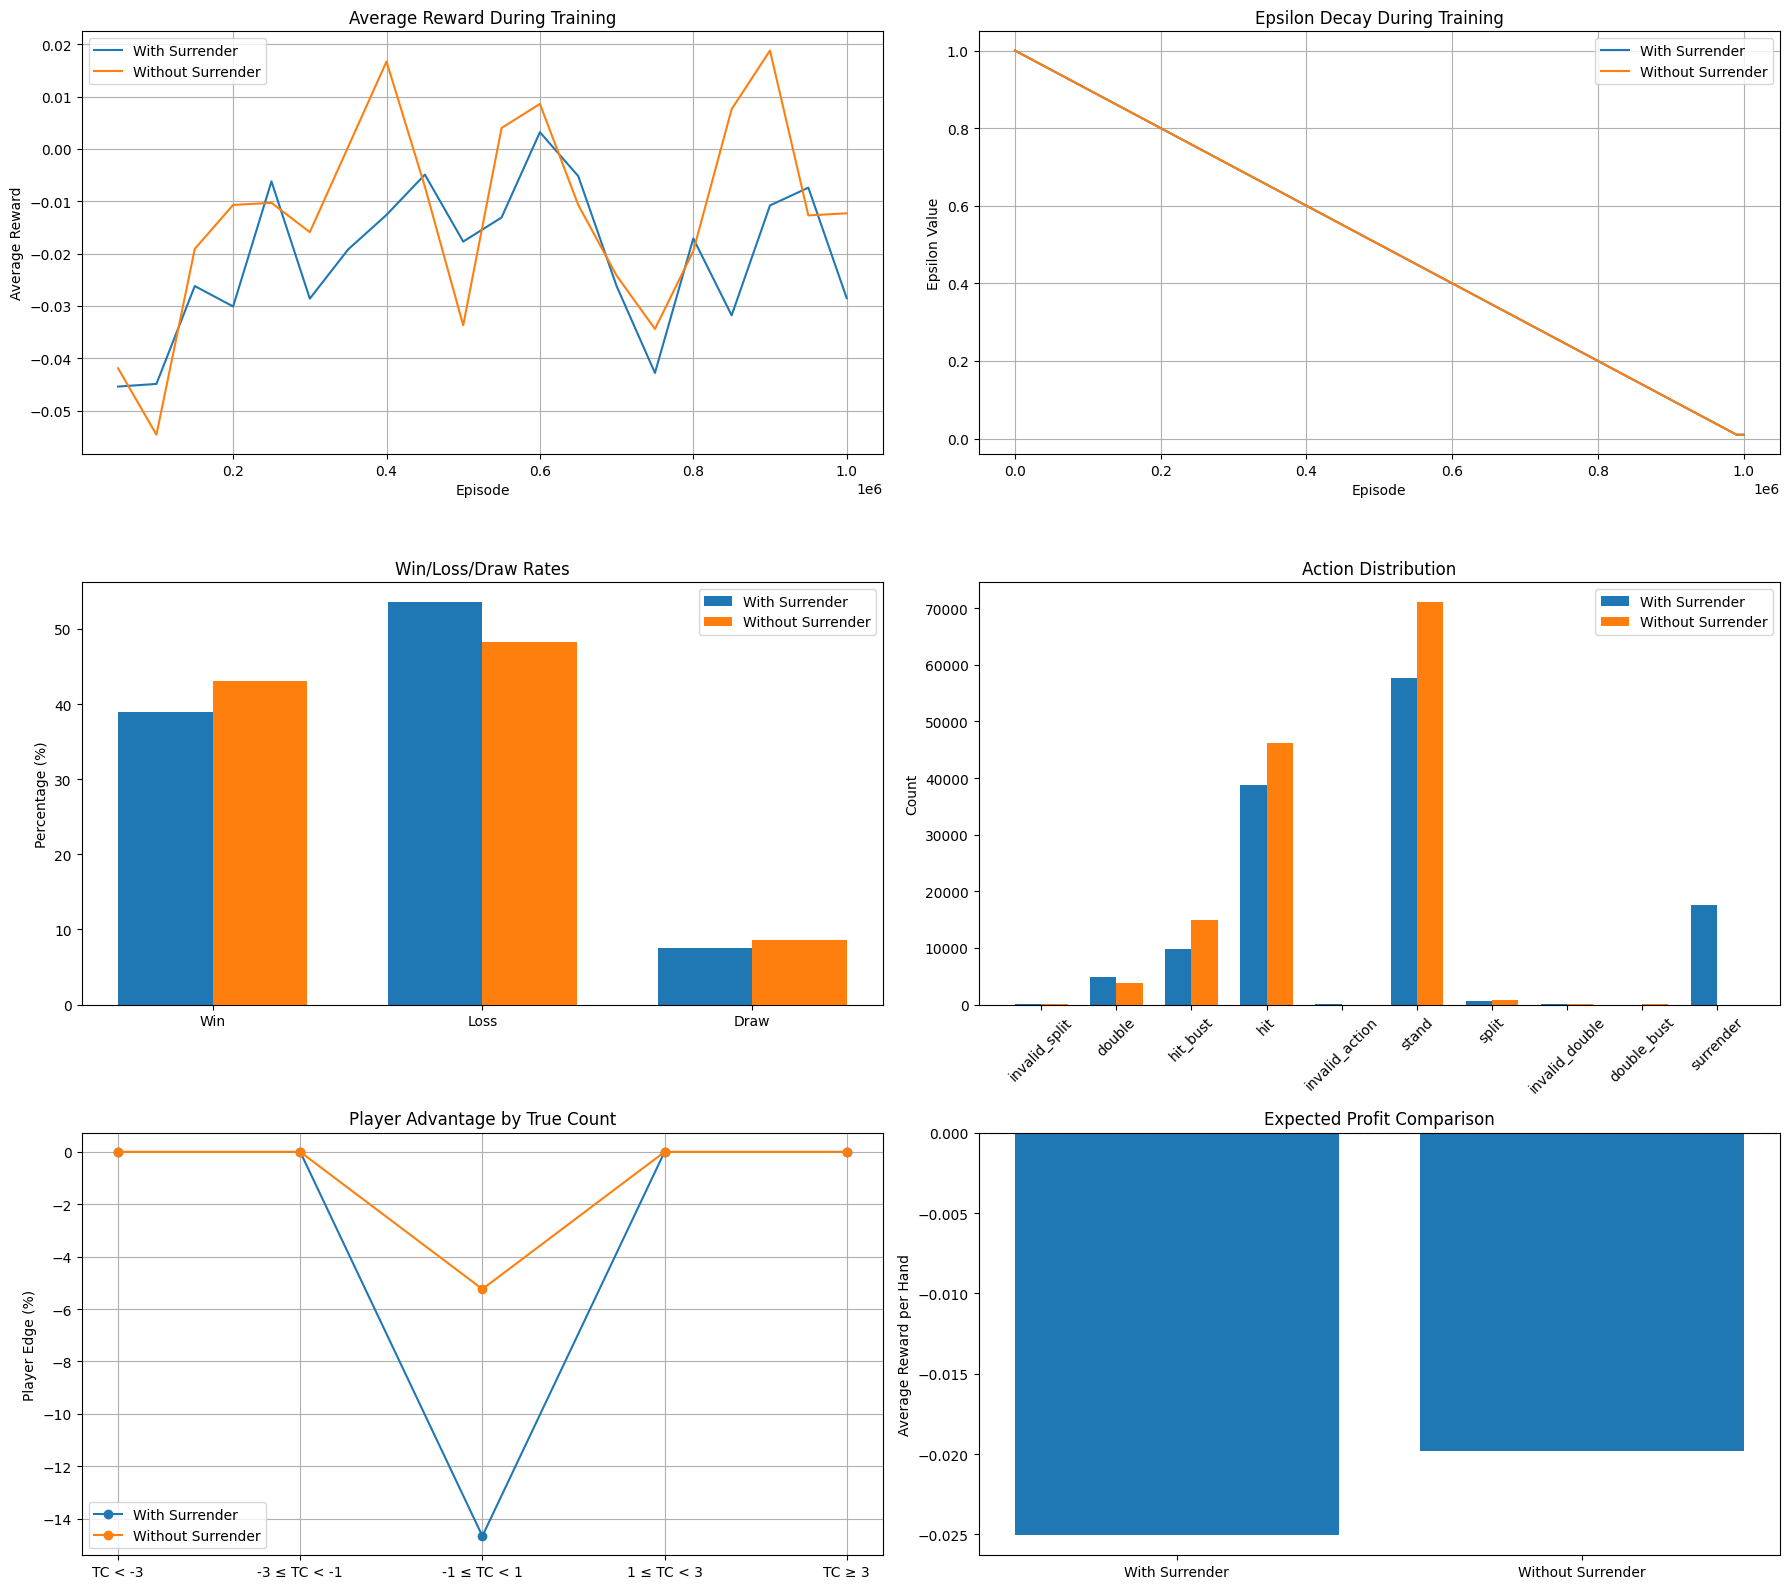

In [ ]:
class CountingBlackjackEnv:
    def __init__(self, num_decks=6, dealer_hits_soft_17=False, allow_late_surrender=True):
        self.num_decks = num_decks
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.allow_late_surrender = allow_late_surrender
        self.reset()

    def reset(self):
        ranks = [str(i) for i in range(2,11)] + ['J','Q','K','A']
        suits = ['H','D','C','S']
        self.deck = [(r,s) for _ in range(self.num_decks) for r in ranks for s in suits]
        random.shuffle(self.deck)
        self.running_count = 0
        self.cards_dealt = 0
        self.player_hand = [self._deal_card(), self._deal_card()]
        self.dealer_hand = [self._deal_card(), self._deal_card()]
        self.can_surrender = self.allow_late_surrender and len(self.player_hand) == 2

        # Check for immediate blackjack
        player_value, _ = self._get_hand_value(self.player_hand)
        dealer_value, _ = self._get_hand_value(self.dealer_hand)

        if player_value == 21 and len(self.player_hand) == 2:  # Player blackjack
            if dealer_value == 21 and len(self.dealer_hand) == 2:  # Both have blackjack
                return self._get_state(), 0, True  # Push
            return self._get_state(), 1.5, True  # Player wins 3:2

        if dealer_value == 21 and len(self.dealer_hand) == 2:  # Dealer blackjack
            return self._get_state(), -1, True  # Player loses

        return self._get_state(), 0, False  # Continue game

    def _deal_card(self):
        if len(self.deck) < 15:  # Reshuffle when deck is low
            self.reset()
            return self.player_hand[0]  # Temporary fix

        card = self.deck.pop()
        self.cards_dealt += 1

        # Hi-Lo counting
        if card[0] in ['2','3','4','5','6']:
            self.running_count += 1
        elif card[0] in ['10','J','Q','K','A']:
            self.running_count -= 1

        return card

    def _get_hand_value(self, hand):
        value, aces = 0, 0
        for card in hand:
            rank = card[0]
            if rank == 'A':
                val = 11
            elif rank in ['J','Q','K']:
                val = 10
            else:
                val = int(rank)
            value += val
            aces += 1 if val == 11 else 0

        while value > 21 and aces > 0:
            value -= 10
            aces -= 1

        return value, aces > 0

    def _get_card_value(self, card):
        rank = card[0]
        if rank == 'A': return 11
        if rank in ['J','Q','K']: return 10
        return int(rank)

    def step(self, action):
        if action != 4:  # If not surrender
            self.can_surrender = False

        if action == 4 and self.can_surrender:  # Surrender
            return None, -0.5, True, {'action':'surrender'}

        elif action == 0:  # Stand
            dealer_value = self._play_dealer()
            player_value, _ = self._get_hand_value(self.player_hand)
            reward = self._resolve_hand(player_value, dealer_value)
            return None, reward, True, {'action':'stand', 'dealer_value':dealer_value}

        elif action == 1:  # Hit
            self.player_hand.append(self._deal_card())
            player_value, _ = self._get_hand_value(self.player_hand)
            if player_value > 21:
                return None, -1, True, {'action':'hit_bust'}
            return self._get_state(), 0, False, {'action':'hit'}

        elif action == 2:  # Double
            if len(self.player_hand) == 2:
                self.player_hand.append(self._deal_card())
                player_value, _ = self._get_hand_value(self.player_hand)
                if player_value > 21:
                    return None, -2, True, {'action':'double_bust'}
                dealer_value = self._play_dealer()
                reward = self._resolve_hand(player_value, dealer_value) * 2
                return None, reward, True, {'action':'double', 'dealer_value':dealer_value}
            return None, -1, True, {'action':'invalid_double'}

        elif action == 3:  # Split
            # Simplified split implementation
            if len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]:
                hand1 = [self.player_hand[0], self._deal_card()]
                hand2 = [self.player_hand[1], self._deal_card()]
                dealer_value = self._play_dealer()
                total = 0
                for hand in [hand1, hand2]:
                    val, _ = self._get_hand_value(hand)
                    total += self._resolve_hand(val, dealer_value)
                return None, total, True, {'action':'split', 'dealer_value':dealer_value}
            return None, -1, True, {'action':'invalid_split'}

        else:  # Invalid action
            return None, -1, True, {'action':'invalid_action'}

    def _play_dealer(self):
        while True:
            val, soft = self._get_hand_value(self.dealer_hand)
            if val < 17 or (val == 17 and soft and self.dealer_hits_soft_17):
                self.dealer_hand.append(self._deal_card())
            else:
                return val

    def _resolve_hand(self, player_value, dealer_value):
        if player_value > 21:
            return -1
        if dealer_value > 21:
            return 1
        if player_value > dealer_value:
            return 1
        if player_value < dealer_value:
            return -1
        return 0

    def _get_true_count(self):
        remaining_cards = len(self.deck)
        if remaining_cards == 0:
            return 0
        decks_remaining = remaining_cards / 52
        return self.running_count / max(decks_remaining, 0.5)

    def _get_state(self):
        player_value, usable_ace = self._get_hand_value(self.player_hand)
        dealer_up = self._get_card_value(self.dealer_hand[0])
        can_double = len(self.player_hand) == 2
        can_split = len(self.player_hand) == 2 and self.player_hand[0][0] == self.player_hand[1][0]

        true_count = self._get_true_count()
        if true_count < -3:
            count_bin = 0
        elif true_count < -1:
            count_bin = 1
        elif true_count < 1:
            count_bin = 2
        elif true_count < 3:
            count_bin = 3
        else:
            count_bin = 4

        return (player_value, dealer_up, int(usable_ace), int(can_double),
                int(can_split), int(self.can_surrender), count_bin)

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.01, discount_factor=0.99,
                 epsilon_start=1.0, epsilon_decay=0.000001, min_epsilon=0.01):
        self.actions = actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        current = self.q_table[state][action]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - current)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

def train_counting_agent(env, agent, num_episodes=1000000, log_interval=10000): # Added log_interval
    epsilon_history = []
    avg_reward_history = [] # Added list to store average rewards
    episode_steps = [] # Added list to store episode numbers for plotting

    for episode in range(1, num_episodes+1):
        state, reward, done = env.reset()
        episode_reward = reward

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        agent.decay_epsilon()
        epsilon_history.append(agent.epsilon)

        if episode % log_interval == 0:
            # Evaluate average reward over a fixed number of episodes
            eval_env = CountingBlackjackEnv(num_decks=env.num_decks, dealer_hits_soft_17=env.dealer_hits_soft_17, allow_late_surrender=env.allow_late_surrender) # Use a separate env for evaluation
            avg_reward = evaluate_counting_agent(eval_env, agent, num_episodes=log_interval // 10, silent=True)['expected_profit'] # Evaluate over a smaller subset
            avg_reward_history.append(avg_reward)
            episode_steps.append(episode)
            print(f"Episode {episode}: Avg Reward = {avg_reward:.4f}")


    return epsilon_history, avg_reward_history, episode_steps # Return avg_reward_history and episode_steps

def evaluate_counting_agent(env, agent, num_episodes=100000, silent=False):
    total_reward = 0
    wins = losses = draws = 0
    action_counts = collections.defaultdict(int)
    surrender_count = 0
    count_based_results = {i: {'wins':0, 'losses':0, 'draws':0, 'count':0} for i in range(5)}

    original_epsilon = agent.epsilon
    agent.epsilon = 0  # Greedy evaluation

    for _ in range(num_episodes):
        state, reward, done = env.reset()
        episode_reward = reward
        initial_count = state[-1] if state is not None else None

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            state = next_state
            episode_reward += reward
            action_counts[info['action']] += 1

            if info['action'] == 'surrender':
                surrender_count += 1

        total_reward += episode_reward

        if initial_count is not None:
            count_based_results[initial_count]['count'] += 1
            if episode_reward > 0:
                wins += 1
                count_based_results[initial_count]['wins'] += 1
            elif episode_reward < 0:
                losses += 1
                count_based_results[initial_count]['losses'] += 1
            else:
                draws += 1
                count_based_results[initial_count]['draws'] += 1

    agent.epsilon = original_epsilon

    metrics = {
        'expected_profit': total_reward / num_episodes,
        'win_rate': wins / num_episodes * 100,
        'loss_rate': losses / num_episodes * 100,
        'draw_rate': draws / num_episodes * 100,
        'surrender_rate': surrender_count / num_episodes * 100,
        'action_distribution': action_counts,
        'count_based_results': count_based_results
    }
    return metrics

def plot_counting_results(with_surrender_metrics, without_surrender_metrics, epsilon_history_with, epsilon_history_without, avg_reward_history_with, avg_reward_history_without, episode_steps_with, episode_steps_without): # Added avg_reward_history and episode_steps
    plt.figure(figsize=(18, 16))

    # 1. Average Reward vs Episodes
    plt.subplot(3, 2, 1)
    plt.plot(episode_steps_with, avg_reward_history_with, label='With Surrender')
    plt.plot(episode_steps_without, avg_reward_history_without, label='Without Surrender')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward During Training')
    plt.legend()
    plt.grid(True)

    # 2. Epsilon Decay
    plt.subplot(3, 2, 2)
    plt.plot(np.arange(len(epsilon_history_with)), epsilon_history_with, label='With Surrender')
    plt.plot(np.arange(len(epsilon_history_without)), epsilon_history_without, label='Without Surrender')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay During Training')
    plt.legend()
    plt.grid(True)


    # 3. Win/Loss/Draw Rates
    plt.subplot(3, 2, 3)
    categories = ['Win', 'Loss', 'Draw']
    with_rates = [with_surrender_metrics['win_rate'],
                 with_surrender_metrics['loss_rate'],
                 with_surrender_metrics['draw_rate']]
    without_rates = [without_surrender_metrics['win_rate'],
                    without_surrender_metrics['loss_rate'],
                    without_surrender_metrics['draw_rate']]

    x = np.arange(len(categories))
    width = 0.35
    plt.bar(x - width/2, with_rates, width, label='With Surrender')
    plt.bar(x + width/2, without_rates, width, label='Without Surrender')
    plt.xticks(x, categories)
    plt.ylabel('Percentage (%)')
    plt.title('Win/Loss/Draw Rates')
    plt.legend()

    # 4. Action Distribution
    plt.subplot(3, 2, 4)
    with_actions = with_surrender_metrics['action_distribution']
    without_actions = without_surrender_metrics['action_distribution']

    actions = list(set(list(with_actions.keys()) + list(without_actions.keys())))
    with_counts = [with_actions.get(a, 0) for a in actions]
    without_counts = [without_actions.get(a, 0) for a in actions]

    x = np.arange(len(actions))
    width = 0.35
    plt.bar(x - width/2, with_counts, width, label='With Surrender')
    plt.bar(x + width/2, without_counts, width, label='Without Surrender')
    plt.xticks(x, actions, rotation=45)
    plt.ylabel('Count')
    plt.title('Action Distribution')
    plt.legend()

    # 5. Performance by True Count
    plt.subplot(3, 2, 5)
    count_ranges = ['TC < -3', '-3 ≤ TC < -1', '-1 ≤ TC < 1', '1 ≤ TC < 3', 'TC ≥ 3']

    with_edges = []
    without_edges = []

    for i in range(5):
        with_total = with_surrender_metrics['count_based_results'][i]['wins'] - with_surrender_metrics['count_based_results'][i]['losses']
        with_count = max(with_surrender_metrics['count_based_results'][i]['count'], 1)
        with_edges.append(with_total / with_count * 100)

        without_total = without_surrender_metrics['count_based_results'][i]['wins'] - without_surrender_metrics['count_based_results'][i]['losses']
        without_count = max(without_surrender_metrics['count_based_results'][i]['count'], 1)
        without_edges.append(without_total / without_count * 100)

    plt.plot(count_ranges, with_edges, marker='o', label='With Surrender')
    plt.plot(count_ranges, without_edges, marker='o', label='Without Surrender')
    plt.ylabel('Player Edge (%)')
    plt.title('Player Advantage by True Count')
    plt.legend()
    plt.grid()

    # 6. Expected Profit Comparison
    plt.subplot(3, 2, 6) # Adjusted subplot index
    plt.bar(['With Surrender', 'Without Surrender'],
            [with_surrender_metrics['expected_profit'], without_surrender_metrics['expected_profit']])
    plt.ylabel('Average Reward per Hand')
    plt.title('Expected Profit Comparison')
    plt.axhline(0, color='gray', linestyle='--')


    plt.tight_layout()
    plt.show()

def train_counting_comparison():
    num_train_episodes = 1000000
    num_eval_episodes = 100000
    log_interval = 50000

    # With Late Surrender and Counting
    print("Training with Late surrender and point counting...")
    env_count_surrender = CountingBlackjackEnv(allow_late_surrender=True)
    agent_count_surrender = QLearningAgent(actions=[0,1,2,3,4])
    epsilon_history_count_surrender, avg_reward_history_count_surrender, episode_steps_count_surrender = train_counting_agent(env_count_surrender, agent_count_surrender, num_train_episodes, log_interval) # Capture avg_reward_history and episode_steps
    print("Evaluating with surrender and counting...")
    metrics_count_surrender = evaluate_counting_agent(env_count_surrender, agent_count_surrender, num_eval_episodes)

    # Without Late Surrender but with Counting
    print("\nTraining without Late surrender...")
    env_count_no_surrender = CountingBlackjackEnv(allow_late_surrender=False)
    agent_count_no_surrender = QLearningAgent(actions=[0,1,2,3])
    epsilon_history_count_no_surrender, avg_reward_history_count_no_surrender, episode_steps_count_no_surrender = train_counting_agent(env_count_no_surrender, agent_count_no_surrender, num_train_episodes, log_interval) # Capture avg_reward_history and episode_steps
    print("Evaluating without surrender but with counting...")
    metrics_count_no_surrender = evaluate_counting_agent(env_count_no_surrender, agent_count_no_surrender, num_eval_episodes)

    # Print results
    print("\nFinal Results with Surrender and Counting:")
    print(f"Expected profit per hand: {metrics_count_surrender['expected_profit']:.4f}")
    print(f"Win rate: {metrics_count_surrender['win_rate']:.2f}%")
    print(f"Loss rate: {metrics_count_surrender['loss_rate']:.2f}%")
    print(f"Draw rate: {metrics_count_surrender['draw_rate']:.2f}%")
    print(f"Surrender rate: {metrics_count_surrender['surrender_rate']:.2f}%")
    print("Action distribution:", dict(metrics_count_surrender['action_distribution']))

    print("\nFinal Results without Surrender but with Counting:")
    print(f"Expected profit per hand: {metrics_count_no_surrender['expected_profit']:.4f}")
    print(f"Win rate: {metrics_count_no_surrender['win_rate']:.2f}%")
    print(f"Loss rate: {metrics_count_no_surrender['loss_rate']:.2f}%")
    print(f"Draw rate: {metrics_count_no_surrender['draw_rate']:.2f}%")
    print("Action distribution:", dict(metrics_count_no_surrender['action_distribution']))

    # Plot results
    plot_counting_results(metrics_count_surrender, metrics_count_no_surrender,
                          epsilon_history_count_surrender, epsilon_history_count_no_surrender,
                          avg_reward_history_count_surrender, avg_reward_history_count_no_surrender,
                          episode_steps_count_surrender, episode_steps_count_no_surrender) # Pass avg_reward_history and episode_steps

if __name__ == "__main__":
    train_counting_comparison()